# Задача 1: Baseline Model

1. Из открытых источников собрать в разбивке "регион РФ + год":  
    - по уровню преступности  
    - по уровню безработицы  
    - по уровню средних заработков  



2. Создать таблицу, где каждая строка содержит данные по одному региону за один год (Регион + год), а в столбцах содержатся значения переменных:  
    - За независимые переменные взять безработицу и уровень заработка;  
    - За целевую переменную взять уровень преступности  
    
    
3. Разбить выборку на train и test и обучить модель регрессии  
4. Проверить качество модели и сделать вывод: работает ли теория Беккера на этих данных?

Импортируем нужные библиотеки:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")

from fuzzywuzzy import fuzz
from functools import reduce

from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras.models import Sequential

from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.options.display.float_format ='{:,.3f}'.format

2022-03-25 17:55:08.169292: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-25 17:55:08.169352: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Функции:

In [2]:
'''
Функция трансформации таблиц со столбцами-регионами и строками-годами в таблицу с столбцом регион_год и показателями по пересечению
'''
def to_one_col(df, name_col):  
    lst_reg = []

    # сделаем цикл для переименования регионов в регион_год:

    for i in df.columns.tolist():
        for j in df.index:
    #         print(str(i)+'_'+str(j))
            lst_reg.append(str(i)+'_'+str(j))

    lst_col = []

    # сделаем цикл для создания одного столбца с уровнем преступности из всего датафрейма crime_T:
    for i in df.columns:
        lst_col.append(df[i].values.tolist())

    lst_col = sum(lst_col, [])  # преобразуем из многомерного в одномерный список

    # создадим пустой датафрейм, который заполним этими столбцами:

    new_crime = pd.DataFrame()
    new_crime['region&year'] = lst_reg
    new_crime['{}'.format(name_col)] = lst_col
    return new_crime

In [3]:
'''
 Функция, принимающая на вход датафрейм, который впоследствии нужно будет добавить к эталонному (преступность), а на выходе отдающую этот датафрейм вместе с двумя новыми столбцами - название региона-эталона, максимально похожее на название региона в датафрейме 
 и степень похожести названий регионов
'''

def stand_names(df):    
    lst_max_fuz = []
    lst_max_name = []
    for i in df['Регион'].tolist():
        lst_f = []
        for j in crim:     # возьмем переменную извне. Это наш эталон
            lst_f.append(fuzz.ratio(i, j))    # при помощи библиотеки fuzzywuzzy найдем уровень сходства между всеми возможными регионами в обеих таблицах - эталонной и поданной на вход
        lst_max_fuz.append(max(lst_f))        # добавим максимальное совпадение
        lst_max_name.append(lst_f.index(max(lst_f)))  # добавим индекс максимального совпадения, чобы по нему подтянуть в таблицу df регион-эталон

    df['Регион_криминал'] = [crime.index[i] for i in lst_max_name]
    df['Регион_совпадение'] = lst_max_fuz

    return df

In [4]:
'''
Функция, возвращающая имя датафрейма. 
'''

def get_df_name(df):     # Функция будет нужна для перебора датафреймов и вывода информации о них
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [5]:
'''
Функция-препроцессинг для доп. признаков. Поскольку признаки были взяты с одного сайта, способ подачи информации в таблицах идентичен. Разнятся только предоставленные годы.
'''

def preprocessing_addit_features(df):
    df1 = df.query('Регион != "Российская Федерация"')    # у всех "лишний" регион - РФ
    df1 = stand_names(df1)        # подтягиваем эталон и считаем степень похожести
    df1['Регион_криминал'][84] = 'Еврейская АО'    # Мы знаем, что неверно определилась Еврейская АО. Меняем!
    df1.index = df1['Регион_криминал']
    df2 = df1.drop(['Регион', 'Регион_криминал', 'Регион_совпадение'], axis=1)
    df2 = df2.T
    ready_df2 = to_one_col(df2, '{}'.format(get_df_name(df)))    # преобразуем таблицу в регион_год и показатель
    return ready_df2

In [6]:
'''
Визуализация - ящик с усмаи и график распределения
'''

def plotting(column):
    print('\x1b[1;0346m'+'Boxplot {}'.format(column.name) +'\x1b[0m')
    sns.boxplot(x=column)
    plt.show()
    print('\x1b[1;0346m'+'Distplot {}'.format(column.name)+'\x1b[0m')
    sns.distplot(column)
    plt.show()

In [7]:
'''
Функция подготовки фичей и таргета, деление датасета и тренировочный и тестовый
'''

def prepare_X_and_y(dataframe, target_name):
    features = dataframe.drop(target_name, axis=1)    # формируем фичи и таргет
    target = dataframe[target_name]
    
    features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.33, random_state=42)
    
    scaler = preprocessing.MinMaxScaler() 
    scaler.fit(features_train)                             # стандартизируем фичи
    features_train = pd.DataFrame(scaler.transform(features_train), columns=features_train.columns)
    features_test = pd.DataFrame(scaler.transform(features_test), columns=features_test.columns) 
    
    return features_train, features_test, target_train, target_test

In [8]:
'''
Линейная регрессия. Поскольку мы будем ее вызывать несколько раз
'''

def linear_regression(X, y, X_test, y_test, columns):
    model = LinearRegression().fit(X, y)
    predict = model.predict(X_test)
    r2 = r2_score(y_test, predict)   
    
    coef = pd.Series(model.coef_, index = columns)
    imp_coef = coef.sort_values()

    plt.rcParams['figure.figsize'] = (8.0, 10.0)
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using Linear Regression Model")
    return r2

### Переходим к задачам. Пункт 1:  
Открываем таблицу, отражающую количество преступлений в регионах (скачана с просторов интернета):

In [9]:
crime_all = pd.read_excel('Преступления.xlsx')
crime_all

,Регионы,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022 январь
0,Алтайский край,"44,940.000","42,102.000","45,024.000",44096,48582,"44,576.000","40,055.000","38,413.000","37,058.000","39,029.000","39,070.000","3,118.000"
1,Амурская область,"18,091.000","17,904.000","16,909.000",17254,19475,"18,656.000","18,505.000","17,536.000","19,508.000","18,422.000","18,231.000","1,282.000"
2,Архангельская область,"24,015.000","22,365.000","20,680.000",19068,22311,"19,994.000","19,193.000","18,962.000","19,150.000","19,074.000","16,996.000","1,244.000"
3,Астраханская область,"22,687.000","20,742.000","17,295.000",15799,14774,"13,893.000","13,432.000","13,427.000","13,110.000","14,059.000","13,801.000","1,003.000"
4,Белгородская область,"15,895.000","14,888.000","14,930.000",14296,15792,"13,715.000","12,744.000","13,163.000","14,205.000","14,341.000","14,067.000","1,165.000"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,Ямало-Ненецкий АО,"9,395.000","9,121.000","9,150.000",9008,9608,"8,000.000","8,259.000","7,705.000","7,532.000","7,630.000","6,961.000",461.000
91,Ярославская область,"18,483.000","17,277.000","15,390.000",15512,21759,"18,401.000","17,873.000","16,710.000","17,709.000","16,088.000","16,066.000","1,051.000"
92,г. Москва,"173,628.000","180,240.000","174,990.000",182873,195239,"173,898.000","140,134.000","140,542.000","142,081.000","146,559.000","143,564.000","10,476.000"
93,г. Санкт-Петербург,"59,318.000","56,439.000","55,110.000",56463,56480,"52,351.000","52,138.000","51,420.000","48,627.000","61,309.000","62,755.000","4,816.000"


Сразу видим данные за январь 2022 года. Этот год еще только начался, соответственно, этот столбец нам не подходит, т.к. малоинформативен и для нас, и впоследствии для модели. Удалим его:

In [10]:
crime_all = crime_all.drop('2022 январь', axis=1)
crime_all

,Регионы,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Алтайский край,"44,940.000","42,102.000","45,024.000",44096,48582,"44,576.000","40,055.000","38,413.000","37,058.000","39,029.000","39,070.000"
1,Амурская область,"18,091.000","17,904.000","16,909.000",17254,19475,"18,656.000","18,505.000","17,536.000","19,508.000","18,422.000","18,231.000"
2,Архангельская область,"24,015.000","22,365.000","20,680.000",19068,22311,"19,994.000","19,193.000","18,962.000","19,150.000","19,074.000","16,996.000"
3,Астраханская область,"22,687.000","20,742.000","17,295.000",15799,14774,"13,893.000","13,432.000","13,427.000","13,110.000","14,059.000","13,801.000"
4,Белгородская область,"15,895.000","14,888.000","14,930.000",14296,15792,"13,715.000","12,744.000","13,163.000","14,205.000","14,341.000","14,067.000"
...,...,...,...,...,...,...,...,...,...,...,...,...
90,Ямало-Ненецкий АО,"9,395.000","9,121.000","9,150.000",9008,9608,"8,000.000","8,259.000","7,705.000","7,532.000","7,630.000","6,961.000"
91,Ярославская область,"18,483.000","17,277.000","15,390.000",15512,21759,"18,401.000","17,873.000","16,710.000","17,709.000","16,088.000","16,066.000"
92,г. Москва,"173,628.000","180,240.000","174,990.000",182873,195239,"173,898.000","140,134.000","140,542.000","142,081.000","146,559.000","143,564.000"
93,г. Санкт-Петербург,"59,318.000","56,439.000","55,110.000",56463,56480,"52,351.000","52,138.000","51,420.000","48,627.000","61,309.000","62,755.000"


Идём дальше. Согласно Конституции России, Российская Федерация является федеративным государством и состоит из 85 равноправных субъектов — республик, краёв, областей, городов федерального значения, автономных округов и автономной области. У нас выгружены 95 строк. Посмотрим, что является лишним:

In [11]:
crime_all['Регионы'].tolist()

['Алтайский край',
 'Амурская область',
 'Архангельская область',
 'Астраханская область',
 'Белгородская область',
 'Брянская область',
 'Владимирская область',
 'Волгоградская область',
 'Вологодская область',
 'Воронежская область',
 'Дальневосточный ФО',
 'Еврейская АО',
 'Забайкальский край',
 'Ивановская область',
 'Иркутская область',
 'Кабардино-Балкарская Респ.',
 'Калининградская область',
 'Калужская область',
 'Камчатский край',
 'Карачаево-Черкесская Респ.',
 'Кемеровская область-Кузбасс',
 'Кировская область',
 'Костромская область',
 'Краснодарский край',
 'Красноярский край',
 'Крымский ФО',
 'Курганская область',
 'Курская область',
 'Ленинградская область',
 'Липецкая область',
 'Магаданская область',
 'Московская область',
 'Мурманская область',
 'Ненецкий АО',
 'Нижегородская область',
 'Новгородская  область',
 'Новосибирская область',
 'Омская область',
 'Оренбургская область',
 'Орловская область',
 'Пензенская область',
 'Пермский край',
 'Приволжский ФО',
 'При

У нас здесь также собраны и федеральные округа, и даже есть строка, посвященная общим цифрам по России. Отфильтруем по ним:

In [12]:
no_need = crime_all[crime_all['Регионы'].str.contains('ФО|Федерация', regex=True) == True]['Регионы'].tolist()
print('Всего таких субъектов: {}'.format(len(no_need)))
no_need

Всего таких субъектов: 10


['Дальневосточный ФО',
 'Крымский ФО',
 'Приволжский ФО',
 'Российская Федерация',
 'Северо-Западный ФО',
 'Северо-Кавказский ФО',
 'Сибирский ФО',
 'Уральский ФО',
 'Центральный ФО',
 'Южный ФО']

Теперь всё сходится: 85 субъектов РФ + 9 федеральных округов + сама Российская Федерация. Уберём ненужные нам строки (всё, что не является регионом РФ):

In [13]:
crime = crime_all.query('Регионы not in @no_need').reset_index(drop=True)
crime

,Регионы,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Алтайский край,"44,940.000","42,102.000","45,024.000",44096,48582,"44,576.000","40,055.000","38,413.000","37,058.000","39,029.000","39,070.000"
1,Амурская область,"18,091.000","17,904.000","16,909.000",17254,19475,"18,656.000","18,505.000","17,536.000","19,508.000","18,422.000","18,231.000"
2,Архангельская область,"24,015.000","22,365.000","20,680.000",19068,22311,"19,994.000","19,193.000","18,962.000","19,150.000","19,074.000","16,996.000"
3,Астраханская область,"22,687.000","20,742.000","17,295.000",15799,14774,"13,893.000","13,432.000","13,427.000","13,110.000","14,059.000","13,801.000"
4,Белгородская область,"15,895.000","14,888.000","14,930.000",14296,15792,"13,715.000","12,744.000","13,163.000","14,205.000","14,341.000","14,067.000"
...,...,...,...,...,...,...,...,...,...,...,...,...
80,Ямало-Ненецкий АО,"9,395.000","9,121.000","9,150.000",9008,9608,"8,000.000","8,259.000","7,705.000","7,532.000","7,630.000","6,961.000"
81,Ярославская область,"18,483.000","17,277.000","15,390.000",15512,21759,"18,401.000","17,873.000","16,710.000","17,709.000","16,088.000","16,066.000"
82,г. Москва,"173,628.000","180,240.000","174,990.000",182873,195239,"173,898.000","140,134.000","140,542.000","142,081.000","146,559.000","143,564.000"
83,г. Санкт-Петербург,"59,318.000","56,439.000","55,110.000",56463,56480,"52,351.000","52,138.000","51,420.000","48,627.000","61,309.000","62,755.000"


Теперь посмотрим на пропуски, которые видны уже сейчас:

In [14]:
crime.columns[crime.isna().any()]

Index([2011, 2012, 2013], dtype='object')

In [15]:
crime.isna().sum()

Регионы    0
2011       2
2012       2
2013       2
2014       0
2015       0
2016       0
2017       0
2018       0
2019       0
2020       0
2021       0
dtype: int64

Итак, их всего по 2 в каждом из трех наиболее ранних годах. Посмотрим на эти пропуски, в каких регионах они представлены:

In [16]:
crime[crime[2011].isna() == True]

,Регионы,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
51,Республика Крым,NaN,NaN,NaN,18248,27842,"23,747.000","21,711.000","22,414.000","20,979.000","21,682.000","20,727.000"
84,г. Севастополь,NaN,NaN,NaN,5703,8276,"5,703.000","4,859.000","4,083.000","4,238.000","6,104.000","6,136.000"


Действительно, до 2014 года Крым и Севастополь не были в составе Российской Федерации.  
Поскольку эта информация впоследствии станет целевой переменной, заполнять пропуски мы не будем. Оставим пока как есть, но в перспективе вернемся к этому вопросу.

Далее по условиям нам необходимо создать новую таблицу для последующего объединения таблиц. 
Для этого мы сразу же транспонируем таблицу, чтобы впоследствии было удобнее вывести новую таблицу:

In [17]:
crime.index = crime['Регионы']
crime = crime.drop('Регионы', axis=True)
crime_T = crime.T
crime_T

Регионы,Алтайский край,Амурская область,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Вологодская область,Воронежская область,...,Ханты-Мансийский АО - Югра,Челябинская область,Чеченская Республика,Чувашская Республика,Чукотский АО,Ямало-Ненецкий АО,Ярославская область,г. Москва,г. Санкт-Петербург,г. Севастополь
2011,"44,940.000","18,091.000","24,015.000","22,687.000","15,895.000","19,467.000","23,831.000","40,017.000","25,289.000","27,027.000",...,"31,152.000","77,053.000","4,254.000","17,990.000",728.000,"9,395.000","18,483.000","173,628.000","59,318.000",NaN
2012,"42,102.000","17,904.000","22,365.000","20,742.000","14,888.000","18,733.000","21,753.000","39,143.000","23,826.000","27,682.000",...,"27,407.000","70,557.000","3,919.000","16,534.000",839.000,"9,121.000","17,277.000","180,240.000","56,439.000",NaN
2013,"45,024.000","16,909.000","20,680.000","17,295.000","14,930.000","19,060.000","18,640.000","36,507.000","24,429.000","30,437.000",...,"25,223.000","67,693.000","3,636.000","14,156.000",794.000,"9,150.000","15,390.000","174,990.000","55,110.000",NaN
2014,"44,096.000","17,254.000","19,068.000","15,799.000","14,296.000","17,100.000","18,807.000","36,417.000","24,460.000","33,747.000",...,"24,140.000","62,708.000","3,500.000","13,782.000",645.000,"9,008.000","15,512.000","182,873.000","56,463.000","5,703.000"
2015,"48,582.000","19,475.000","22,311.000","14,774.000","15,792.000","17,323.000","21,348.000","41,696.000","29,230.000","39,298.000",...,"23,785.000","70,602.000","3,425.000","15,688.000",814.000,"9,608.000","21,759.000","195,239.000","56,480.000","8,276.000"
2016,"44,576.000","18,656.000","19,994.000","13,893.000","13,715.000","15,821.000","19,138.000","38,742.000","25,724.000","34,370.000",...,"22,598.000","64,576.000","3,723.000","13,836.000",800.000,"8,000.000","18,401.000","173,898.000","52,351.000","5,703.000"
2017,"40,055.000","18,505.000","19,193.000","13,432.000","12,744.000","14,447.000","18,257.000","39,881.000","20,492.000","32,571.000",...,"22,648.000","68,213.000","3,953.000","12,794.000",712.000,"8,259.000","17,873.000","140,134.000","52,138.000","4,859.000"
2018,"38,413.000","17,536.000","18,962.000","13,427.000","13,163.000","14,287.000","17,263.000","38,539.000","17,866.000","29,308.000",...,"21,276.000","64,862.000","3,330.000","11,824.000",748.000,"7,705.000","16,710.000","140,542.000","51,420.000","4,083.000"
2019,"37,058.000","19,508.000","19,150.000","13,110.000","14,205.000","14,369.000","16,787.000","41,122.000","17,726.000","30,808.000",...,"20,699.000","66,567.000","3,779.000","12,430.000",775.000,"7,532.000","17,709.000","142,081.000","48,627.000","4,238.000"
2020,"39,029.000","18,422.000","19,074.000","14,059.000","14,341.000","15,178.000","17,371.000","38,687.000","17,314.000","29,530.000",...,"20,977.000","63,366.000","3,139.000","13,048.000",786.000,"7,630.000","16,088.000","146,559.000","61,309.000","6,104.000"


Теперь соберем новую таблицу, где в первом столбце будут названия регионов с годом, а во втором - уровень преступности на пересечении этих критериев:

Подготовим итоговый вариант таблицы:

In [18]:
ready_crime = to_one_col(crime_T, 'crime')

Сравним с исходным: нет ли ошибок:

In [19]:
ready_crime[:25]

,region&year,crime
0,Алтайский край_2011,"44,940.000"
1,Алтайский край_2012,"42,102.000"
2,Алтайский край_2013,"45,024.000"
3,Алтайский край_2014,"44,096.000"
4,Алтайский край_2015,"48,582.000"
5,Алтайский край_2016,"44,576.000"
6,Алтайский край_2017,"40,055.000"
7,Алтайский край_2018,"38,413.000"
8,Алтайский край_2019,"37,058.000"
9,Алтайский край_2020,"39,029.000"


In [20]:
crime.head(3)

,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Регионы,,,,,,,,,,,
Алтайский край,"44,940.000","42,102.000","45,024.000",44096,48582,"44,576.000","40,055.000","38,413.000","37,058.000","39,029.000","39,070.000"
Амурская область,"18,091.000","17,904.000","16,909.000",17254,19475,"18,656.000","18,505.000","17,536.000","19,508.000","18,422.000","18,231.000"
Архангельская область,"24,015.000","22,365.000","20,680.000",19068,22311,"19,994.000","19,193.000","18,962.000","19,150.000","19,074.000","16,996.000"


Сохраним в переменной названия регионов как эталон для других таблиц:

In [21]:
crim = crime_T.columns.tolist()
crim[:3]

['Алтайский край', 'Амурская область', 'Архангельская область']

In [22]:
del crime_all, crime_T, no_need

Всё ок. Идем к следующей таблице:

### Уровень безработицы

In [23]:
unemploy_all = pd.read_excel('Безработица.xlsx')
unemploy_all

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Белгородская область,6.100,6.400,8.100,8.300,6.200,5.900,5.600,4.300,3.900,...,3.700,4.000,4.000,4.100,4.000,3.900,4.000,3.900,4.900,4.000
1,Брянская область,13.400,9.800,8.600,7.400,8.900,6.800,6.800,6.400,6.500,...,5.100,5.200,5.000,4.600,4.600,4.400,3.900,3.800,4.000,3.300
2,Владимирская область,12,10.200,10.400,10.200,9.100,9,10.800,6.700,5.700,...,4.400,3.800,4.300,5.600,5.600,4.800,4.700,4.000,5.600,3.600
3,Воронежская область,10.100,9.600,8.900,8.300,8.700,7.600,5.400,5.200,5.200,...,5.500,4.700,4.500,4.500,4.500,4.300,3.700,3.500,4.300,3.400
4,Ивановская область,10.400,5.900,6.900,6.500,4.700,6.900,4.200,4.300,5.200,...,6.300,5.200,4.300,5.600,5.600,4.700,4.200,3.800,5.400,4.400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Амурская область,13.700,12.300,10.700,9.800,11.700,9.900,8.200,6.100,5.400,...,5.300,6.100,5.600,5.800,5.900,5.900,5.600,5.400,6.000,5.200
81,Магаданская область,11,11.400,8.200,10,8,6.900,5.300,5.600,7.200,...,3.400,2.900,3.100,4.300,4.400,5.300,5.100,4.600,5.700,4.500
82,Сахалинская область,13.200,12.100,9.400,9.400,7.400,7.700,4.800,4.600,7.400,...,7.700,7.200,6.500,6.300,6.300,6.000,5.300,5.200,5.500,5.200
83,Еврейская автономная область,15,9.400,9.100,6.900,8,7.900,9.800,9.300,9.600,...,8.500,8.300,8.700,7.900,8.200,8.300,7.000,6.200,6.300,5.100


In [24]:
unemp = unemploy_all['Регион'].tolist()
unemp[:3]

['Белгородская область', 'Брянская область', 'Владимирская область']

 Воспользуемся библиотекой, выявляющей нечёткое сходство, чтобы подтянуть регионы из эталона в эту таблицу:

In [25]:
unemploy = stand_names(unemploy_all)
unemploy

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
0,Белгородская область,6.100,6.400,8.100,8.300,6.200,5.900,5.600,4.300,3.900,...,4.000,4.100,4.000,3.900,4.000,3.900,4.900,4.000,Белгородская область,100
1,Брянская область,13.400,9.800,8.600,7.400,8.900,6.800,6.800,6.400,6.500,...,5.000,4.600,4.600,4.400,3.900,3.800,4.000,3.300,Брянская область,100
2,Владимирская область,12,10.200,10.400,10.200,9.100,9,10.800,6.700,5.700,...,4.300,5.600,5.600,4.800,4.700,4.000,5.600,3.600,Владимирская область,100
3,Воронежская область,10.100,9.600,8.900,8.300,8.700,7.600,5.400,5.200,5.200,...,4.500,4.500,4.500,4.300,3.700,3.500,4.300,3.400,Воронежская область,100
4,Ивановская область,10.400,5.900,6.900,6.500,4.700,6.900,4.200,4.300,5.200,...,4.300,5.600,5.600,4.700,4.200,3.800,5.400,4.400,Ивановская область,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Амурская область,13.700,12.300,10.700,9.800,11.700,9.900,8.200,6.100,5.400,...,5.600,5.800,5.900,5.900,5.600,5.400,6.000,5.200,Амурская область,100
81,Магаданская область,11,11.400,8.200,10,8,6.900,5.300,5.600,7.200,...,3.100,4.300,4.400,5.300,5.100,4.600,5.700,4.500,Магаданская область,100
82,Сахалинская область,13.200,12.100,9.400,9.400,7.400,7.700,4.800,4.600,7.400,...,6.500,6.300,6.300,6.000,5.300,5.200,5.500,5.200,Сахалинская область,100
83,Еврейская автономная область,15,9.400,9.100,6.900,8,7.900,9.800,9.300,9.600,...,8.700,7.900,8.200,8.300,7.000,6.200,6.300,5.100,Тверская область,64


Как мы видим, не везде 100% совпадение. Посмотрим на те строки, где совпадение менее 100:

In [26]:
unemploy_all[['Регион', 'Регион_криминал', 'Регион_совпадение']][unemploy_all['Регион_совпадение'] < 100].sort_values('Регион_совпадение', ascending=False)

,Регион,Регион_криминал,Регион_совпадение
26,Новгородская область,Новгородская область,98
48,Удмуртская Республика,Удмуртская Республика,98
70,Кемеровская область,Кировская область,89
39,Кабардино-Балкарская Республика,Кабардино-Балкарская Респ.,88
40,Карачаево-Черкесская Республика,Карачаево-Черкесская Респ.,88
41,Республика Северная Осетия - Алания,Республика Сев. Осетия-Алания,88
60,Ханты-Мансийский автономный округ - Югра,Ханты-Мансийский АО - Югра,73
83,Еврейская автономная область,Тверская область,64
61,Ямало-Ненецкий автономный округ,Ямало-Ненецкий АО,62
84,Чукотский автономный округ,Чукотский АО,53


Итак, ошибка всего в двух строчках: Кемеровская область и Еврейская АО. Отфильтруем их по вхождению подстрок - регионов в столбце Эталона и посмотрим на них поближе:

In [27]:
unemploy_all[unemploy_all['Регион_криминал'].str.contains('Твер|Кир|Евр|Кем', regex=True)]

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
14,Тверская область,9.100,7.500,4.700,6.600,5.400,5.800,4.500,4.100,5.100,...,5.300,5.600,5.800,4.500,4.100,4.000,4.400,3.800,Тверская область,100
51,Кировская область,8.200,7.700,6.800,7.300,8.600,7.200,7.900,5.800,7.200,...,5.100,5.300,5.400,5.300,5.100,4.800,5.400,4.700,Кировская область,100
70,Кемеровская область,10.600,9.900,9.300,9.900,9.900,8.600,7.400,6.200,6.600,...,6.200,7.700,7.900,7.100,6.100,5.500,6.700,5.400,Кировская область,89
83,Еврейская автономная область,15,9.400,9.100,6.900,8,7.900,9.800,9.300,9.600,...,8.700,7.900,8.200,8.300,7.000,6.200,6.300,5.100,Тверская область,64


Итак, видно, что ошибка действительно затронула две строчки. Поскольку в столбце "Регион_криминал" нет Еврейской АО и Кемеровской области, исправим ошибки вручную:

In [28]:
unemploy_all['Регион_криминал'][70] = 'Кемеровская область-Кузбасс'
unemploy_all['Регион_криминал'][83] = 'Еврейская АО'

unemploy_all[68:]

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
68,Красноярский край,12.200,9.700,7.800,9.200,8,9.500,8.700,7.600,6.400,...,5.000,6.200,6.100,5.700,4.900,4.500,6.000,3.200,Красноярский край,100
69,Иркутская область,11.600,11.200,11.100,11.200,10.300,9.800,8.500,8.000,8.500,...,8.800,8.200,8.800,8.700,7.600,6.600,7.700,6.200,Иркутская область,100
70,Кемеровская область,10.600,9.900,9.300,9.900,9.900,8.600,7.400,6.200,6.600,...,6.200,7.700,7.900,7.100,6.100,5.500,6.700,5.400,Кемеровская область-Кузбасс,89
71,Новосибирская область,13.300,12.400,11.400,11.100,9.100,7.900,7.400,7.000,7.300,...,5.100,6.900,7.400,6.000,6.700,6.100,6.700,5.900,Новосибирская область,100
72,Омская область,14,10,9.500,9.700,9,8.700,9.100,8.000,7.800,...,6.700,6.800,7.200,7.000,6.800,6.500,8.900,5.700,Омская область,100
73,Томская область,13,9.900,11.200,13.700,10.100,10.500,8.900,6.800,8.100,...,7.600,7.700,7.200,6.300,6.300,5.500,8.700,6.400,Томская область,100
74,Республика Бурятия,19.100,18.400,15.400,17.800,15.300,12.200,14.200,13.100,12.000,...,8.400,9.200,9.600,9.600,9.300,9.200,10.500,9.400,Республика Бурятия,100
75,Республика Саха (Якутия),11.200,8.200,7.100,9.400,9,9.200,9.500,7.700,9.000,...,7.400,7.300,7.200,7.100,6.900,6.900,7.400,6.600,Республика Саха (Якутия),100
76,Забайкальский край,14.400,16.200,11.100,14.200,12.600,8.600,6.200,8.700,14.900,...,10.000,10.400,10.800,10.700,10.200,9.300,9.800,9.100,Забайкальский край,100
77,Камчатский край,16.300,14.500,11.600,12.400,10.300,8.400,8.100,9.000,8.600,...,6.100,4.500,4.100,4.300,4.900,3.800,3.800,3.300,Камчатский край,100


Отлично! Теперь осталось лишь подготовить данные для функции создания таблицы для объединения с эталоном. А для этого мы отберем только те года, которые представлены в эталоне и удалим остальные - ненужные - столбцы: 

In [29]:
unemploy_all.index = unemploy_all['Регион_криминал']
unemploy = unemploy_all[[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]]
unemploy = unemploy.T
unemploy

Регион_криминал,Белгородская область,Брянская область,Владимирская область,Воронежская область,Ивановская область,Калужская область,Костромская область,Курская область,Липецкая область,Московская область,...,Республика Саха (Якутия),Забайкальский край,Камчатский край,Приморский край,Хабаровский край,Амурская область,Магаданская область,Сахалинская область,Еврейская АО,Чукотский АО
2011,4.300,7.100,5.700,6.400,6.600,5.600,5.100,6.300,4.900,3.700,...,9.000,10.600,6.100,8.000,6.600,6.000,4.500,7.900,8.500,5.600
2012,3.700,5.100,4.400,5.500,6.300,4.300,4.800,5.100,3.600,2.900,...,8.000,10.600,5.800,6.900,6.400,5.300,3.400,7.700,8.500,4.300
2013,4.000,5.200,3.800,4.700,5.200,4.500,4.900,4.600,3.700,2.800,...,7.400,10.500,5.700,7.100,5.700,6.100,2.900,7.200,8.300,3.300
2014,4.000,5.000,4.300,4.500,4.300,4.200,4.300,3.900,3.700,2.700,...,7.400,10.000,6.100,6.900,5.900,5.600,3.100,6.500,8.700,3.200
2015,4.100,4.600,5.600,4.500,5.600,4.300,5.300,4.200,4.100,3.300,...,7.300,10.400,4.500,6.900,5.300,5.800,4.300,6.300,7.900,4.000
2016,4.000,4.600,5.600,4.500,5.600,4.200,5.500,4.300,4.000,3.300,...,7.200,10.800,4.100,6.000,5.000,5.900,4.400,6.300,8.200,3.500
2017,3.900,4.400,4.800,4.300,4.700,4.000,5.300,4.100,3.900,3.200,...,7.100,10.700,4.300,5.400,4.900,5.900,5.300,6.000,8.300,2.900
2018,4.000,3.900,4.700,3.700,4.200,3.900,4.500,4.000,3.800,2.700,...,6.900,10.200,4.900,5.400,3.800,5.600,5.100,5.300,7.000,3.100
2019,3.900,3.800,4.000,3.500,3.800,3.700,4.100,4.000,3.700,2.700,...,6.900,9.300,3.800,5.200,3.800,5.400,4.600,5.200,6.200,3.800
2020,4.900,4.000,5.600,4.300,5.400,4.700,5.500,4.900,4.300,3.600,...,7.400,9.800,3.800,5.500,4.000,6.000,5.700,5.500,6.300,4.400


In [30]:
ready_unemploy = to_one_col(unemploy, 'unemploy')
ready_unemploy[:25]

,region&year,unemploy
0,Белгородская область_2011,4.300
1,Белгородская область_2012,3.700
2,Белгородская область_2013,4.000
3,Белгородская область_2014,4.000
4,Белгородская область_2015,4.100
5,Белгородская область_2016,4.000
6,Белгородская область_2017,3.900
7,Белгородская область_2018,4.000
8,Белгородская область_2019,3.900
9,Белгородская область_2020,4.900


Отлично. Идём дальше:

### Уровень зарплат

In [31]:
salary_all = pd.read_excel('Зарплаты.xlsx')
salary_all

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Адыгея,"1,303.000","1,832.000","2,613.000","3,318.000","4,266.000","5,123.000","6,414.000","8,056.000","10,097.000",...,"16,715.000","19,276.000","20,945.000",22087,23109,24490,27469,30192,32161,28823
1,Алтай,"1,248.000","1,902.000","3,058.000","3,817.000","4,550.000","5,736.000","7,438.000","9,228.000","11,454.000",...,"18,265.000","20,722.000","22,598.000",22903,25083,26316,30953,33387,36269,34649
2,Алтайский край,"1,365.000","1,870.000","2,568.000","3,148.000","3,955.000","4,914.000","6,147.000","7,805.000","9,732.000",...,"16,010.000","18,011.000","19,456.000",20090,21202,22743,25519,27962,30072,29129
3,Амурская обл.,"2,232.000","3,147.000","4,692.000","5,930.000","7,354.000","9,392.000","11,111.000","13,534.000","16,665.000",...,"26,789.000","30,542.000","32,397.000",32902,33837,37368,42315,47234,52430,48140
4,Архангельская обл.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"26,374.000","30,205.000","33,125.000",35592,38118,40352,45427,49435,52779,51360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Чечня,882.000,"1,590.000","2,508.000","3,808.000","5,021.000","6,716.000","8,078.000","9,917.000","11,763.000",...,"17,385.000","20,865.000","21,452.000",22304,22926,23249,26177,27757,29771,29283
82,Чувашия,"1,196.000","1,726.000","2,461.000","3,215.000","4,048.000","5,073.000","6,437.000","8,703.000","11,147.000",...,"17,187.000","19,388.000","20,854.000",21369,22908,24530,27036,29671,31844,32042
83,Чукотский АО,"5,687.000","8,216.000","13,502.000","17,271.000","18,618.000","23,314.000","25,703.000","30,859.000","38,317.000",...,"60,807.000","68,261.000","76,285.000",79531,86647,91995,98864,107107,120641,78189
84,Ямало-Ненецкий АО,"8,965.000","12,577.000","15,876.000","20,027.000","23,890.000","27,534.000","32,336.000","37,364.000","44,169.000",...,"63,696.000","69,192.000","74,489.000",77272,83238,89938,97204,101012,111216,98427


У нас 86 строк в таблице. Что-то явно лишнее. Проверим:

In [32]:
len(salary_all['Регион'].unique())  # дублей нет. Возможно, это РФ в целом

86

In [33]:
salary_all[salary_all['Регион'].str.contains('Росс', regex=False)]['Регион']

55    Россия
Name: Регион, dtype: object

Точно! Это строка, посвященная всей стране. Она нам не нужна, уберём её:

In [34]:
salary_all = salary_all.query('Регион != "Россия"')
salary_all

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Адыгея,"1,303.000","1,832.000","2,613.000","3,318.000","4,266.000","5,123.000","6,414.000","8,056.000","10,097.000",...,"16,715.000","19,276.000","20,945.000",22087,23109,24490,27469,30192,32161,28823
1,Алтай,"1,248.000","1,902.000","3,058.000","3,817.000","4,550.000","5,736.000","7,438.000","9,228.000","11,454.000",...,"18,265.000","20,722.000","22,598.000",22903,25083,26316,30953,33387,36269,34649
2,Алтайский край,"1,365.000","1,870.000","2,568.000","3,148.000","3,955.000","4,914.000","6,147.000","7,805.000","9,732.000",...,"16,010.000","18,011.000","19,456.000",20090,21202,22743,25519,27962,30072,29129
3,Амурская обл.,"2,232.000","3,147.000","4,692.000","5,930.000","7,354.000","9,392.000","11,111.000","13,534.000","16,665.000",...,"26,789.000","30,542.000","32,397.000",32902,33837,37368,42315,47234,52430,48140
4,Архангельская обл.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"26,374.000","30,205.000","33,125.000",35592,38118,40352,45427,49435,52779,51360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Чечня,882.000,"1,590.000","2,508.000","3,808.000","5,021.000","6,716.000","8,078.000","9,917.000","11,763.000",...,"17,385.000","20,865.000","21,452.000",22304,22926,23249,26177,27757,29771,29283
82,Чувашия,"1,196.000","1,726.000","2,461.000","3,215.000","4,048.000","5,073.000","6,437.000","8,703.000","11,147.000",...,"17,187.000","19,388.000","20,854.000",21369,22908,24530,27036,29671,31844,32042
83,Чукотский АО,"5,687.000","8,216.000","13,502.000","17,271.000","18,618.000","23,314.000","25,703.000","30,859.000","38,317.000",...,"60,807.000","68,261.000","76,285.000",79531,86647,91995,98864,107107,120641,78189
84,Ямало-Ненецкий АО,"8,965.000","12,577.000","15,876.000","20,027.000","23,890.000","27,534.000","32,336.000","37,364.000","44,169.000",...,"63,696.000","69,192.000","74,489.000",77272,83238,89938,97204,101012,111216,98427


Вызываем функцию для подтягивания названий регионов из эталона:

In [35]:
salary = stand_names(salary_all)
salary

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
0,Адыгея,"1,303.000","1,832.000","2,613.000","3,318.000","4,266.000","5,123.000","6,414.000","8,056.000","10,097.000",...,"20,945.000",22087,23109,24490,27469,30192,32161,28823,Республика Адыгея,52
1,Алтай,"1,248.000","1,902.000","3,058.000","3,817.000","4,550.000","5,736.000","7,438.000","9,228.000","11,454.000",...,"22,598.000",22903,25083,26316,30953,33387,36269,34649,Алтайский край,53
2,Алтайский край,"1,365.000","1,870.000","2,568.000","3,148.000","3,955.000","4,914.000","6,147.000","7,805.000","9,732.000",...,"19,456.000",20090,21202,22743,25519,27962,30072,29129,Алтайский край,100
3,Амурская обл.,"2,232.000","3,147.000","4,692.000","5,930.000","7,354.000","9,392.000","11,111.000","13,534.000","16,665.000",...,"32,397.000",32902,33837,37368,42315,47234,52430,48140,Амурская область,83
4,Архангельская обл.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,"33,125.000",35592,38118,40352,45427,49435,52779,51360,Архангельская область,87
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Чечня,882.000,"1,590.000","2,508.000","3,808.000","5,021.000","6,716.000","8,078.000","9,917.000","11,763.000",...,"21,452.000",22304,22926,23249,26177,27757,29771,29283,Чеченская Республика,40
82,Чувашия,"1,196.000","1,726.000","2,461.000","3,215.000","4,048.000","5,073.000","6,437.000","8,703.000","11,147.000",...,"20,854.000",21369,22908,24530,27036,29671,31844,32042,Чувашская Республика,44
83,Чукотский АО,"5,687.000","8,216.000","13,502.000","17,271.000","18,618.000","23,314.000","25,703.000","30,859.000","38,317.000",...,"76,285.000",79531,86647,91995,98864,107107,120641,78189,Чукотский АО,100
84,Ямало-Ненецкий АО,"8,965.000","12,577.000","15,876.000","20,027.000","23,890.000","27,534.000","32,336.000","37,364.000","44,169.000",...,"74,489.000",77272,83238,89938,97204,101012,111216,98427,Ямало-Ненецкий АО,100


Здесь всё интереснее: не так много 100% совпадений. Посмотрим, на каком этапе регионы определяются неверно:

In [36]:
salary[['Регион', 'Регион_криминал', 'Регион_совпадение']][salary['Регион_совпадение'] < 80].sort_values('Регион_совпадение', ascending=False)

,Регион,Регион_криминал,Регион_совпадение
25,Карачаево-Черкесия,Карачаево-Черкесская Респ.,77
20,Кабардино-Балкария,Кабардино-Балкарская Респ.,77
27,Кемеровская обл.,Кировская область,73
6,Башкортостан,Республика Башкортостан,69
65,Северная Осетия - Алания,Республика Сев. Осетия-Алания,64
18,Ингушетия,Республика Ингушетия,62
69,Татарстан,Республика Татарстан,62
14,Дагестан,Республика Дагестан,59
22,Калмыкия,Республика Калмыкия,59
39,Марий Эл,Республика Марий Эл,59


У нас 3 ошибки: никак не хочет определяться верно Кемеровская область и в этот раз республики Алтай и Саха (Якутия) вполне логично (для fuzzywuzzy) определились как подстроки Алтайского края и Сахалинской области.  
Исправим вручную, как и ранее:

In [37]:
salary['Регион_криминал'][1] = 'Республика Алтай'
salary['Регион_криминал'][27] = 'Кемеровская область-Кузбасс'
salary['Регион_криминал'][61] = 'Республика Саха (Якутия)'


salary[(salary.index == 1) | (salary.index == 27) | (salary.index == 61)]  # перепроверка

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
1,Алтай,"1,248.000","1,902.000","3,058.000","3,817.000","4,550.000","5,736.000","7,438.000","9,228.000","11,454.000",...,"22,598.000",22903,25083,26316,30953,33387,36269,34649,Республика Алтай,53
27,Кемеровская обл.,"2,425.000","3,313.000","4,248.000","5,264.000","6,707.000","8,654.000","10,408.000","12,555.000","15,410.000",...,"26,809.000",28263,30115,32648,38023,41770,43429,24377,Кемеровская область-Кузбасс,73
61,Саха,"4,539.000","6,052.000","8,172.000","9,697.000","11,315.000","13,437.000","16,168.000","19,409.000","23,816.000",...,"51,111.000",54631,59000,62206,68871,73402,77178,74510,Республика Саха (Якутия),35


In [38]:
salary[(salary.index == 27) | (salary.index == 61)]

,Регион,2000,2001,2002,2003,2004,2005,2006,2007,2008,...,2014,2015,2016,2017,2018,2019,2020,2021,Регион_криминал,Регион_совпадение
27,Кемеровская обл.,"2,425.000","3,313.000","4,248.000","5,264.000","6,707.000","8,654.000","10,408.000","12,555.000","15,410.000",...,"26,809.000",28263,30115,32648,38023,41770,43429,24377,Кемеровская область-Кузбасс,73
61,Саха,"4,539.000","6,052.000","8,172.000","9,697.000","11,315.000","13,437.000","16,168.000","19,409.000","23,816.000",...,"51,111.000",54631,59000,62206,68871,73402,77178,74510,Республика Саха (Якутия),35


Ок. Теперь подготовим таблицу к джойну с эталоном:

In [39]:
salary.index = salary['Регион_криминал']
salary = salary[[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]]
salary = salary.T
salary

Регион_криминал,Республика Адыгея,Республика Алтай,Алтайский край,Амурская область,Архангельская область,Астраханская область,Республика Башкортостан,Белгородская область,Брянская область,Республика Бурятия,...,Ульяновская область,Хабаровский край,Республика Хакасия,Ханты-Мансийский АО - Югра,Челябинская область,Чеченская Республика,Чувашская Республика,Чукотский АО,Ямало-Ненецкий АО,Ярославская область
2011,"14,345.000","15,632.000","13,823.000","24,202.000","22,882.000","17,023.000","18,397.000","17,668.000","13,912.000","19,924.000",...,"15,009.000","26,156.000","20,690.000","45,498.000","20,015.000","14,431.000","14,896.000","53,369.000","59,095.000","18,111.000"
2012,"16,715.000","18,265.000","16,010.000","26,789.000","26,374.000","19,522.000","20,265.000","20,002.000","16,530.000","23,101.000",...,"17,107.000","31,076.000","23,467.000","50,841.000","22,501.000","17,385.000","17,187.000","60,807.000","63,696.000","20,397.000"
2013,"19,276.000","20,722.000","18,011.000","30,542.000","30,205.000","22,736.000","22,377.000","22,221.000","18,974.000","26,038.000",...,"19,187.000","34,132.000","26,068.000","54,508.000","25,651.000","20,865.000","19,388.000","68,261.000","69,192.000","23,003.000"
2014,"20,945.000","22,598.000","19,456.000","32,397.000","33,125.000","24,576.000","24,988.000","23,895.000","20,911.000","27,739.000",...,"21,272.000","36,781.000","29,085.000","57,976.000","27,683.000","21,452.000","20,854.000","76,285.000","74,489.000","25,434.000"
2015,"22,087.000","22,903.000","20,090.000","32,902.000","35,592.000","25,499.000","25,928.000","25,456.000","21,679.000","28,386.000",...,"22,846.000","38,041.000","29,935.000","60,068.000","29,642.000","22,304.000","21,369.000","79,531.000","77,272.000","26,748.000"
2016,"23,109.000","25,083.000","21,202.000","33,837.000","38,118.000","27,493.000","28,108.000","27,091.000","22,923.000","29,969.000",...,"24,334.000","40,109.000","32,515.000","63,568.000","30,941.000","22,926.000","22,908.000","86,647.000","83,238.000","28,520.000"
2017,"24,490.000","26,316.000","22,743.000","37,368.000","40,352.000","29,599.000","30,358.000","29,066.000","24,743.000","32,237.000",...,"26,254.000","42,465.000","33,978.000","66,719.000","32,253.000","23,249.000","24,530.000","91,995.000","89,938.000","30,720.000"
2018,"27,469.000","30,953.000","25,519.000","42,315.000","45,427.000","33,630.000","33,753.000","31,852.000","27,251.000","36,047.000",...,"28,353.000","47,153.000","37,874.000","70,896.000","35,219.000","26,177.000","27,036.000","98,864.000","97,204.000","33,474.000"
2019,"30,192.000","33,387.000","27,962.000","47,234.000","49,435.000","36,093.000","36,465.000","34,615.000","29,853.000","39,115.000",...,"30,677.000","50,213.000","40,548.000","75,087.000","37,433.000","27,757.000","29,671.000","107,107.000","101,012.000","36,016.000"
2020,"32,161.000","36,269.000","30,072.000","52,430.000","52,779.000","38,885.000","38,738.000","37,442.000","31,946.000","41,800.000",...,"32,504.000","53,113.000","43,800.000","79,822.000","39,349.000","29,771.000","31,844.000","120,641.000","111,216.000","37,820.000"


In [40]:
ready_salary = to_one_col(salary, 'salary')
ready_salary[:25]

,region&year,salary
0,Республика Адыгея_2011,"14,345.000"
1,Республика Адыгея_2012,"16,715.000"
2,Республика Адыгея_2013,"19,276.000"
3,Республика Адыгея_2014,"20,945.000"
4,Республика Адыгея_2015,"22,087.000"
5,Республика Адыгея_2016,"23,109.000"
6,Республика Адыгея_2017,"24,490.000"
7,Республика Адыгея_2018,"27,469.000"
8,Республика Адыгея_2019,"30,192.000"
9,Республика Адыгея_2020,"32,161.000"


Удостоверимся, что всё верно: перепроверим размеры готовых датасетов:

In [41]:
ready_crime.shape, ready_unemploy.shape, ready_salary.shape

((935, 2), (935, 2), (935, 2))

Отлично.  
Теперь подгрузим несколько дополнительных таблиц (доп. признаки), которые позже также отправим в общую ~~кучу~~ таблицу.  
Сделаем это сейчас, а не во втором задании, чтобы больше не возвращаться к предобработке.

Какие показатели будем брать:  
- коэффициенты рождаемости и смертности
- усреднённая стоимость набора продуктов питания
- усреднённая численность постоянного населения
- число браков и разводов
- медицинский показатель: суммарное количество людей, которым оказана мед помощь

In [42]:
birth = pd.read_excel('./Доп фичи/Суммарный_коэффициент_рождаемости.xlsx')
death = pd.read_excel('./Доп фичи/Возрастные_коэффициенты_смертности.xlsx')
eat = pd.read_excel('./Доп фичи/Стоимость_условного_(минимального)_набора_продуктов_питания.xlsx')
population = pd.read_excel('./Доп фичи/Численность_постоянного_населения_в_среднем_за_год.xlsx')
wedding = pd.read_excel('./Доп фичи/Число_зарегистрированных_браков.xlsx')
divorce = pd.read_excel('./Доп фичи/Число_разводов_за_год.xlsx')
medicine = pd.read_excel('./Доп фичи/Численность_лиц,_которым_оказана_помощь_амбулаторно_и_при_выездах.xlsx')

Поскольку данные взяты из одного источника, то они примерно одинаковы:

In [43]:
for i in [birth, death, eat, population, wedding, divorce, medicine]:
    print(get_df_name(i))
    print("Рзмер: ", i.shape)
    print("Название столбцов: ", i.columns)
    print()

birth.head()    # выведем пример датафрейма

birth
Рзмер:  (86, 11)
Название столбцов:  Index(['Регион', 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021], dtype='object')

death
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021],
      dtype='object')

eat
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021],
      dtype='object')

population
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021],
      dtype='object')

wedding
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020,
       2021],
      dtype='object')

divorce
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020],
      dtype='object')

medicine
Рзмер:  (86, 12)
Название столбцов:  Index(['Регион', 2010, 2

,Регион,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Российская Федерация,1.690,1.710,1.750,1.770,1.760,1.620,1.580,1.500,1.510,1.500
1,Белгородская область,1.510,1.530,1.540,1.560,1.540,1.390,1.360,1.290,1.240,1.260
2,Брянская область,1.560,1.530,1.560,1.650,1.610,1.430,1.430,1.320,1.310,1.270
3,Владимирская область,1.620,1.590,1.640,1.730,1.710,1.520,1.490,1.350,1.270,1.270
4,Воронежская область,1.450,1.440,1.470,1.510,1.480,1.370,1.340,1.270,1.280,1.250


Получается, что у нас в целом датафреймы похожи. Они имеют одинаковое количество регионов, но столбцы (годы) иногда разнятся. 

Hа всякий случай перепроверим, действительно ли у нас повторяются названия регионов:

In [44]:
len(list(set(birth['Регион'].tolist() + death['Регион'].tolist() + eat['Регион'].tolist() + population['Регион'].tolist() + wedding['Регион'].tolist() + divorce['Регион'].tolist() + medicine['Регион'].tolist())))

86

Действительно, регионы имеют одинаковое название. Значит, мы можем использовать только одну функцию для предобработки всех этих файлов. Но сначала убедимся, что везде лишней строкой является Российская Федерация, т.е. есть ли в принципе во всех датафреймах такое значение:

In [45]:
for i in [birth, death, eat, population, wedding, divorce, medicine]:
    a = 'Регион'
    try:
        print("В датафрейме", get_df_name(i), "есть значение", i[i[a].str.contains('Российская Федерация', regex=False) == True][a].values[0])
    except:
        print("В датафрейме", get_df_name(i), 'значения "Российская Федерация" нет')

В датафрейме birth есть значение Российская Федерация
В датафрейме death есть значение Российская Федерация
В датафрейме eat есть значение Российская Федерация
В датафрейме population есть значение Российская Федерация
В датафрейме wedding есть значение Российская Федерация
В датафрейме divorce есть значение Российская Федерация
В датафрейме medicine есть значение Российская Федерация


Вернемся к недостающим годам: заполним пропуски, т.к. у нас пропущенными получаются целые годы - по 85 значений за один год.  
Заполнять будем линейной регрессией, т.к. эту задачу можно считать временным рядом, а линейная регрессия хорошо справляется с временными рядами:

Для начала заменим пропуски в таблице birth - там не хватает 2011 года:

In [46]:
birth_new = birth.dropna()
birth_new[2011] = np.nan
m = LinearRegression().fit(birth_new[np.arange(2013,2022)], birth_new[2012])
birth_new.loc[birth_new[birth_new[2011].isna()].index, 2011] = m.predict(birth_new[birth_new[2011].isna()][np.arange(2013,2022)])
birth_crimea = birth[birth[2012].isna()]
birth_crimea[2011] = np.nan
birth_new = pd.concat([birth_new, birth_crimea])
birth_new = birth_new.sort_index()
birth_new

,Регион,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2011
0,Российская Федерация,1.690,1.710,1.750,1.770,1.760,1.620,1.580,1.500,1.510,1.500,1.693
1,Белгородская область,1.510,1.530,1.540,1.560,1.540,1.390,1.360,1.290,1.240,1.260,1.511
2,Брянская область,1.560,1.530,1.560,1.650,1.610,1.430,1.430,1.320,1.310,1.270,1.514
3,Владимирская область,1.620,1.590,1.640,1.730,1.710,1.520,1.490,1.350,1.270,1.270,1.583
4,Воронежская область,1.450,1.440,1.470,1.510,1.480,1.370,1.340,1.270,1.280,1.250,1.419
...,...,...,...,...,...,...,...,...,...,...,...,...
81,Амурская область,1.830,1.840,1.850,1.830,1.810,1.710,1.650,1.530,1.540,1.510,1.828
82,Магаданская область,1.650,1.690,1.660,1.660,1.590,1.600,1.510,1.420,1.510,1.380,1.663
83,Сахалинская область,1.710,1.810,1.960,2.010,2.150,2.020,1.950,1.950,1.970,1.930,1.799
84,Еврейская автономная область,1.840,1.860,1.950,2.020,1.980,1.810,1.850,1.730,1.710,1.650,1.879


Теперь статистику по разводам:

In [47]:
divorce_new = divorce
divorce_new[2021] = np.nan
m = LinearRegression().fit(divorce_new[np.arange(2015,2020)], divorce_new[2020])
divorce_new.loc[divorce_new[divorce_new[2021].isna()].index, 2021] = m.predict(divorce_new[divorce_new[2021].isna()][np.arange(2015,2020)])
divorce_new

,Регион,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Российская Федерация,"639,321.000","669,376.000","644,101.000","667,971.000","693,730.000","611,645.990","608,336.000","611,436.000","583,942.000","620,729.990","564,703.990","564,689.232"
1,Белгородская область,"6,612.000","6,977.990","6,916.000","7,717.990","7,654.000","6,774.000","6,787.000","6,782.000","6,753.000","6,518.990","6,345.000","6,190.632"
2,Брянская область,"6,278.000","6,586.000","6,649.000","5,908.000","7,121.000","5,882.990","5,803.990","5,529.000","5,401.000","5,406.000","5,173.000","5,318.630"
3,Владимирская область,"6,391.000","6,745.000","6,485.000","6,945.000","6,795.000","5,861.000","5,592.000","5,798.000","5,508.000","5,503.000","4,771.000","5,056.522"
4,Воронежская область,"11,059.990","11,589.000","10,847.990","11,701.000","11,204.000","9,666.000","9,617.000","9,546.000","9,652.000","10,137.990","9,492.000","8,891.953"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Амурская область,"4,455.000","5,122.000","4,663.000","4,929.990","4,913.000","4,150.990","4,088.000","3,978.000","4,097.000","4,179.000","3,706.000","3,745.519"
82,Магаданская область,"1,016.000","1,085.000","1,046.000","1,042.000","1,035.000",911.000,928.000,873.000,721.000,758.000,707.000,871.915
83,Сахалинская область,"3,124.000","3,352.990","3,166.000","2,824.000","3,233.000","2,885.000","2,794.000","2,732.000","2,729.000","2,832.000","2,465.000","2,557.632"
84,Еврейская автономная область,938.000,890.000,861.000,926.000,989.000,812.000,773.000,795.000,770.000,789.000,663.000,701.790


И медицину:

In [48]:
medicine_new = medicine
medicine_new[2021] = np.nan
m = LinearRegression().fit(medicine_new[np.arange(2015,2020)], medicine_new[2020])
medicine_new.loc[medicine_new[medicine_new[2021].isna()].index, 2021] = m.predict(medicine_new[medicine_new[2021].isna()][np.arange(2015,2020)])
medicine_new

,Регион,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Российская Федерация,"50,702,699.000","50,293,971.000","50,173,682.000","48,051,845.000","48,054,923.000","45,909,892.000","47,265,782.000","45,721,338.000","45,634,685.000","45,710,544.000","45,531,131.000","45,525,822.994"
1,Белгородская область,"538,947.000","541,690.000","530,893.000","532,093.000","519,775.990","498,915.990","534,944.000","516,139.990","507,943.000","498,227.990","500,546.990","490,238.126"
2,Брянская область,"420,325.000","415,606.000","410,053.990","401,480.000","405,491.000","396,018.000","413,953.990","404,594.990","392,261.000","396,397.990","379,899.990","384,010.871"
3,Владимирская область,"471,513.000","468,386.000","475,649.990","463,161.000","467,210.000","461,612.990","471,895.990","451,272.990","444,038.990","434,060.000","408,116.000","436,351.578"
4,Воронежская область,"808,030.000","809,470.000","811,038.990","774,572.000","760,275.000","707,416.990","753,059.990","698,022.990","690,196.990","707,252.990","682,540.990","693,277.245"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,Амурская область,"414,575.000","368,512.990","347,464.000","297,791.990","281,116.000","272,486.000","262,431.000","257,121.000","262,191.990","266,321.000","278,016.000","271,866.114"
82,Магаданская область,"75,892.000","68,851.990","65,025.000","59,308.000","57,456.990","51,302.000","53,007.000","52,279.990","49,883.990","50,342.000","52,521.990","48,464.131"
83,Сахалинская область,"236,018.000","224,410.990","219,424.000","203,681.000","193,945.000","183,424.990","199,393.000","182,503.000","180,121.000","183,057.990","190,227.000","179,153.614"
84,Еврейская автономная область,"113,730.000","108,737.000","103,630.000","95,078.990","88,257.000","75,841.000","72,765.990","65,465.990","59,246.990","63,779.990","57,983.000","61,501.009"


Отлично, теперь запускаем функцию трансформации таблиц:

In [49]:
ready_birth = preprocessing_addit_features(birth_new)
ready_birth

,region&year,___
0,Белгородская область_2012,1.510
1,Белгородская область_2013,1.530
2,Белгородская область_2014,1.540
3,Белгородская область_2015,1.560
4,Белгородская область_2016,1.540
...,...,...
930,Чукотский АО_2018,2.020
931,Чукотский АО_2019,1.680
932,Чукотский АО_2020,1.760
933,Чукотский АО_2021,1.710


Проверим, сильно ли отличаются статистические данные после заполнения пропусков:

In [50]:
print(pd.concat([preprocessing_addit_features(birth).describe(), ready_birth.describe()], axis=1))

        birth     ___
count 846.000 929.000
mean    1.694   1.702
std     0.327   0.329
min     1.030   1.030
25%     1.500   1.510
50%     1.640   1.650
75%     1.848   1.850
max     3.480   3.480


Нет, различия нельзя назвать статистически значимыми. Среднее, стандартное отклонение и медиана изменились не сильно.  


Идём дальше:

In [51]:
ready_death = preprocessing_addit_features(death)
ready_death

,region&year,death
0,Белгородская область_2011,14.100
1,Белгородская область_2012,14.000
2,Белгородская область_2013,13.800
3,Белгородская область_2014,14.000
4,Белгородская область_2015,13.900
...,...,...
930,Чукотский АО_2017,9.400
931,Чукотский АО_2018,11.000
932,Чукотский АО_2019,9.100
933,Чукотский АО_2020,10.500


In [52]:
ready_eat = preprocessing_addit_features(eat)
ready_eat

,region&year,eat
0,Белгородская область_2011,"2,279.699"
1,Белгородская область_2012,"2,057.317"
2,Белгородская область_2013,"2,376.204"
3,Белгородская область_2014,"2,622.972"
4,Белгородская область_2015,"3,145.657"
...,...,...
930,Чукотский АО_2017,"9,322.882"
931,Чукотский АО_2018,"10,064.882"
932,Чукотский АО_2019,"10,578.282"
933,Чукотский АО_2020,"10,901.678"


In [53]:
ready_population = preprocessing_addit_features(population)
ready_population

,region&year,population
0,Белгородская область_2011,"1,532,067.000"
1,Белгородская область_2012,"1,534,213.000"
2,Белгородская область_2013,"1,538,529.000"
3,Белгородская область_2014,"1,542,546.000"
4,Белгородская область_2015,"1,546,022.000"
...,...,...
930,Чукотский АО_2017,"49,990.000"
931,Чукотский АО_2018,"49,585.000"
932,Чукотский АО_2019,"49,504.000"
933,Чукотский АО_2020,"49,975.000"


In [54]:
ready_wedding = preprocessing_addit_features(wedding)
ready_wedding

,region&year,wedding
0,Белгородская область_2011,"14,963.990"
1,Белгородская область_2012,"12,400.000"
2,Белгородская область_2013,"13,475.990"
3,Белгородская область_2014,"13,207.000"
4,Белгородская область_2015,"12,859.000"
...,...,...
930,Чукотский АО_2017,415.000
931,Чукотский АО_2018,356.000
932,Чукотский АО_2019,360.000
933,Чукотский АО_2020,282.000


In [55]:
ready_divorce = preprocessing_addit_features(divorce_new)
ready_divorce

,region&year,divorce
0,Белгородская область_2010,"6,612.000"
1,Белгородская область_2011,"6,977.990"
2,Белгородская область_2012,"6,916.000"
3,Белгородская область_2013,"7,717.990"
4,Белгородская область_2014,"7,654.000"
...,...,...
1015,Чукотский АО_2017,278.000
1016,Чукотский АО_2018,239.000
1017,Чукотский АО_2019,247.000
1018,Чукотский АО_2020,227.000


In [56]:
ready_medicine = preprocessing_addit_features(medicine_new)
ready_medicine

,region&year,medicine
0,Белгородская область_2010,"538,947.000"
1,Белгородская область_2011,"541,690.000"
2,Белгородская область_2012,"530,893.000"
3,Белгородская область_2013,"532,093.000"
4,Белгородская область_2014,"519,775.990"
...,...,...
1015,Чукотский АО_2017,"16,401.000"
1016,Чукотский АО_2018,"15,371.990"
1017,Чукотский АО_2019,"13,600.990"
1018,Чукотский АО_2020,"15,203.990"


In [57]:
ready_birth.shape, ready_death.shape, ready_eat.shape, ready_population.shape, ready_wedding.shape, ready_divorce.shape, ready_medicine.shape

((935, 2), (935, 2), (935, 2), (935, 2), (935, 2), (1020, 2), (1020, 2))

В датафреймах с информацией о разводах и медицине на 85 строк больше. Это связано с тем, что в них присутствует 2010 год, который в перспективе будет отсеян, т.к. в статистике преступлений его нет, а приоритетной таблицей будет именно криминальная сводка.  
Начнём объединять таблицы в одну большую:

### Пункт 2. Создём таблицу, где каждая строка содержит данные по одному региону за один год (Регион + год), а в столбцах содержатся значения всех переменных 

Для объединения воспользуемся методом merge:

In [58]:
data_frames = [ready_crime, ready_unemploy, ready_salary, ready_birth, ready_death, ready_eat, ready_population, ready_wedding, ready_divorce, ready_medicine]

In [59]:
all_data = reduce(lambda  left,right: pd.merge(left,right, on=['region&year'], how='left'), data_frames)
all_data.columns = ['region&year', 'crime', 'unemploy', 'salary', 'birth', 'death', 'eat', 'population', 'wedding', 'divorce', 'medicine']   # не всем колонкам с первого раза присвоились названия
all_data

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
0,Алтайский край_2011,"44,940.000",8.500,"13,823.000",1.820,14.600,"2,455.011","2,424,062.000","21,755.980","12,790.000","922,048.000"
1,Алтайский край_2012,"42,102.000",6.200,"16,010.000",1.810,14.600,"2,410.307","2,412,294.000","21,342.990","12,288.000","965,362.990"
2,Алтайский край_2013,"45,024.000",8.300,"18,011.000",1.830,14.200,"2,719.917","2,402,990.000","20,270.990","13,258.990","911,412.000"
3,Алтайский край_2014,"44,096.000",7.200,"19,456.000",1.840,14.200,"2,977.796","2,394,694.000","18,476.000","13,243.000","853,407.990"
4,Алтайский край_2015,"48,582.000",8.000,"20,090.000",1.810,14.100,"3,381.100","2,387,725.000","16,208.990","10,662.000","802,975.000"
...,...,...,...,...,...,...,...,...,...,...,...
930,г. Севастополь_2017,"4,859.000",4.600,"27,687.000",1.560,13.100,"4,079.918","422,507.000","4,317.990","1,961.000","112,905.990"
931,г. Севастополь_2018,"4,083.000",4.300,"31,814.000",1.440,12.800,"4,182.438","432,712.000","3,345.000","1,938.000","122,466.990"
932,г. Севастополь_2019,"4,238.000",3.900,"34,621.000",1.400,13.000,"4,580.128","439,941.000","3,824.000","2,035.000","121,198.000"
933,г. Севастополь_2020,"6,104.000",4.600,"36,300.000",1.310,13.200,"4,511.372","446,174.000","3,092.000","1,927.000","134,632.990"


Проверим на пропуски целевую переменную:

In [60]:
all_data[all_data['crime'].isna()]

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
561,Республика Крым_2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
562,Республика Крым_2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
563,Республика Крым_2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
924,г. Севастополь_2011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
925,г. Севастополь_2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
926,г. Севастополь_2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
nan_target = all_data[all_data["crime"].isna()].index.tolist()
nan_target

[561, 562, 563, 924, 925, 926]

Поскольку в таргете домысливать мы не можем, а в остальных столбцах точно так же отсутствуют данные, удалим эти строки как совершенно неинформативные.

In [62]:
all_data = all_data.query('index not in @nan_target')
all_data.shape

(929, 11)

Идём дальше. Посмотрим на количество пропусков в остальных столбцах:

In [63]:
all_data.isna().sum().sort_values(ascending=True)

region&year    0
crime          0
birth          0
death          0
medicine       0
unemploy       2
salary         2
eat            2
population     2
wedding        2
divorce        2
dtype: int64

Мы видим одинаковое количество пропусков. Возможно, это один и тот же регион?

In [64]:
all_data[all_data['unemploy'].isna()]

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
564,Республика Крым_2014,"18,248.000",NaN,NaN,1.820,15.200,NaN,NaN,NaN,NaN,"632,300.990"
927,г. Севастополь_2014,"5,703.000",NaN,NaN,1.650,13.900,NaN,NaN,NaN,NaN,"135,520.990"


Как и следовало предполагать, это данные за 2014 год по Крыму и Севастополю за 2014 год. Поскольку таргет у нас присутствует и он достоверен (из источника гос. статистики), теоретически мы могли бы заполнить эти строки, однако, принимая во внимание, что baseline-модель у нас будет строиться на столбцах unemploy и salary, а они как раз не заполнены за 2014 год, то выдумывать числа и подставлять их не очень разумно. Также можно обратить внимание на то, что, помимо этих столбцов, пропуски также есть в столбцах eat, population, wedding и divorce. Т.е. нет значений в 6 из 9 столбцов - фичей. В таком случае удаляем.

In [65]:
all_data = all_data.query('index not in [564, 927]')
all_data.shape

(927, 11)

In [66]:
all_data.isna().sum().sort_values(ascending=True)

region&year    0
crime          0
unemploy       0
salary         0
birth          0
death          0
eat            0
population     0
wedding        0
divorce        0
medicine       0
dtype: int64

In [67]:
all_data[all_data['birth'].isna()]

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine


Пропусков нет, теперь можно посмотреть на данные:

In [68]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927 entries, 0 to 934
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region&year  927 non-null    object 
 1   crime        927 non-null    float64
 2   unemploy     927 non-null    float64
 3   salary       927 non-null    float64
 4   birth        927 non-null    float64
 5   death        927 non-null    float64
 6   eat          927 non-null    float64
 7   population   927 non-null    float64
 8   wedding      927 non-null    float64
 9   divorce      927 non-null    float64
 10  medicine     927 non-null    float64
dtypes: float64(10), object(1)
memory usage: 86.9+ KB


Почти все столбцы имеют формат вещественных чисел, однако не везде такой формат подходит.  
Посмотрим на описание столбцов:  
- уровень преступности - формат float  
- уровень безработицы - формат float  
- зарплата - формат float  
- коэфициент рождаемости - формат float  
- коэфициент смертности - формат float  
- потребительская корзина - формат float  
- численность постоянного населения - а тут уже необходимо округлить до целых чисел (формат integer)  
- число зарегистрированных браков - формат int  
- число разводов за год - формат int   
- численность лиц, которым оказана помощь амбулаторно и при выездах - формат int  

Соответственно, в последних 4-х столбцах меняем формат на целочисленный:

In [69]:
all_data[['population',  'wedding', 'divorce', 'medicine']] = all_data[['population',  'wedding', 'divorce', 'medicine']].astype('int64')
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 927 entries, 0 to 934
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   region&year  927 non-null    object 
 1   crime        927 non-null    float64
 2   unemploy     927 non-null    float64
 3   salary       927 non-null    float64
 4   birth        927 non-null    float64
 5   death        927 non-null    float64
 6   eat          927 non-null    float64
 7   population   927 non-null    int64  
 8   wedding      927 non-null    int64  
 9   divorce      927 non-null    int64  
 10  medicine     927 non-null    int64  
dtypes: float64(6), int64(4), object(1)
memory usage: 86.9+ KB


In [70]:
all_data.head()

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
0,Алтайский край_2011,"44,940.000",8.500,"13,823.000",1.820,14.600,"2,455.011",2424062,21755,12790,922048
1,Алтайский край_2012,"42,102.000",6.200,"16,010.000",1.810,14.600,"2,410.307",2412294,21342,12288,965362
2,Алтайский край_2013,"45,024.000",8.300,"18,011.000",1.830,14.200,"2,719.917",2402990,20270,13258,911412
3,Алтайский край_2014,"44,096.000",7.200,"19,456.000",1.840,14.200,"2,977.796",2394694,18476,13243,853407
4,Алтайский край_2015,"48,582.000",8.000,"20,090.000",1.810,14.100,"3,381.100",2387725,16208,10662,802975


Прекрасно, переходим к анализу данных:

In [71]:
all_data.describe()

,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
count,927.000,927.000,927.000,927.000,927.000,927.000,927.000,927.000,927.000,927.000
mean,"25,014.691",6.605,"33,757.932",1.702,13.051,"3,832.499","1,750,528.232","12,616.327","7,372.575","559,004.174"
std,"24,541.246",4.389,"16,577.434",0.329,2.953,"1,173.704","1,761,776.727","13,753.476","7,288.341","542,519.966"
min,511.000,0.800,"11,236.000",1.030,3.000,"2,043.889","42,110.000",159.000,136.000,"11,982.000"
25%,"10,307.000",4.400,"23,130.000",1.510,11.700,"3,030.504","747,767.500","5,032.000","2,942.000","249,960.000"
50%,"16,909.000",5.600,"29,441.000",1.650,13.400,"3,688.791","1,196,339.000","8,196.000","5,001.000","398,387.000"
75%,"31,058.500",7.400,"37,858.000",1.850,15.000,"4,384.002","2,397,836.500","15,343.500","9,735.000","753,530.000"
max,"195,239.000",48.100,"120,641.000",3.480,19.600,"11,794.042","12,666,565.000","100,482.000","47,980.000","4,028,333.000"


Что можно сказать: каждый из этих столбцов подвержен выбросам. Так, например, в целевом приpнаке 75 процентиль показывает значение чуть больше 31 тысячи, в то время как максимальное значение - 195 тысяч. Сильный скос.  
Выведем 2 графика: боксплот и график распределения:

Boxplot crime


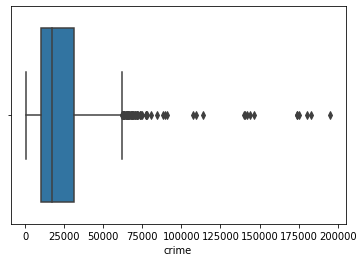

Distplot crime


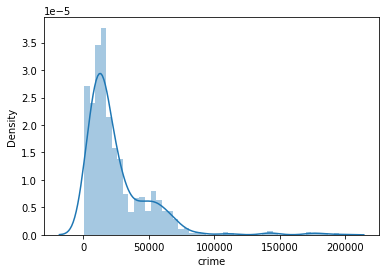

In [72]:
plotting(all_data['crime'])

Да, вот они - выбросы. Дистплот скошен вправо. Стоит ли убирать выбросы - решим после анализа других столбцов.

Выведем график отношения между всеми переменными и посчитаем корреляцию: 

,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine
crime,1.000,-0.270,0.080,-0.172,0.061,-0.126,0.936,0.936,0.949,0.943
unemploy,-0.270,1.000,-0.242,0.511,-0.490,-0.127,-0.260,-0.262,-0.319,-0.248
salary,0.080,-0.242,1.000,0.012,-0.349,0.828,0.107,0.065,0.091,0.076
birth,-0.172,0.511,0.012,1.000,-0.474,-0.025,-0.200,-0.157,-0.228,-0.191
death,0.061,-0.490,-0.349,-0.474,1.000,-0.266,-0.029,-0.019,0.060,-0.011
eat,-0.126,-0.127,0.828,-0.025,-0.266,1.000,-0.109,-0.166,-0.137,-0.144
population,0.936,-0.260,0.107,-0.200,-0.029,-0.109,1.000,0.962,0.961,0.984
wedding,0.936,-0.262,0.065,-0.157,-0.019,-0.166,0.962,1.000,0.975,0.969
divorce,0.949,-0.319,0.091,-0.228,0.060,-0.137,0.961,0.975,1.000,0.967
medicine,0.943,-0.248,0.076,-0.191,-0.011,-0.144,0.984,0.969,0.967,1.000


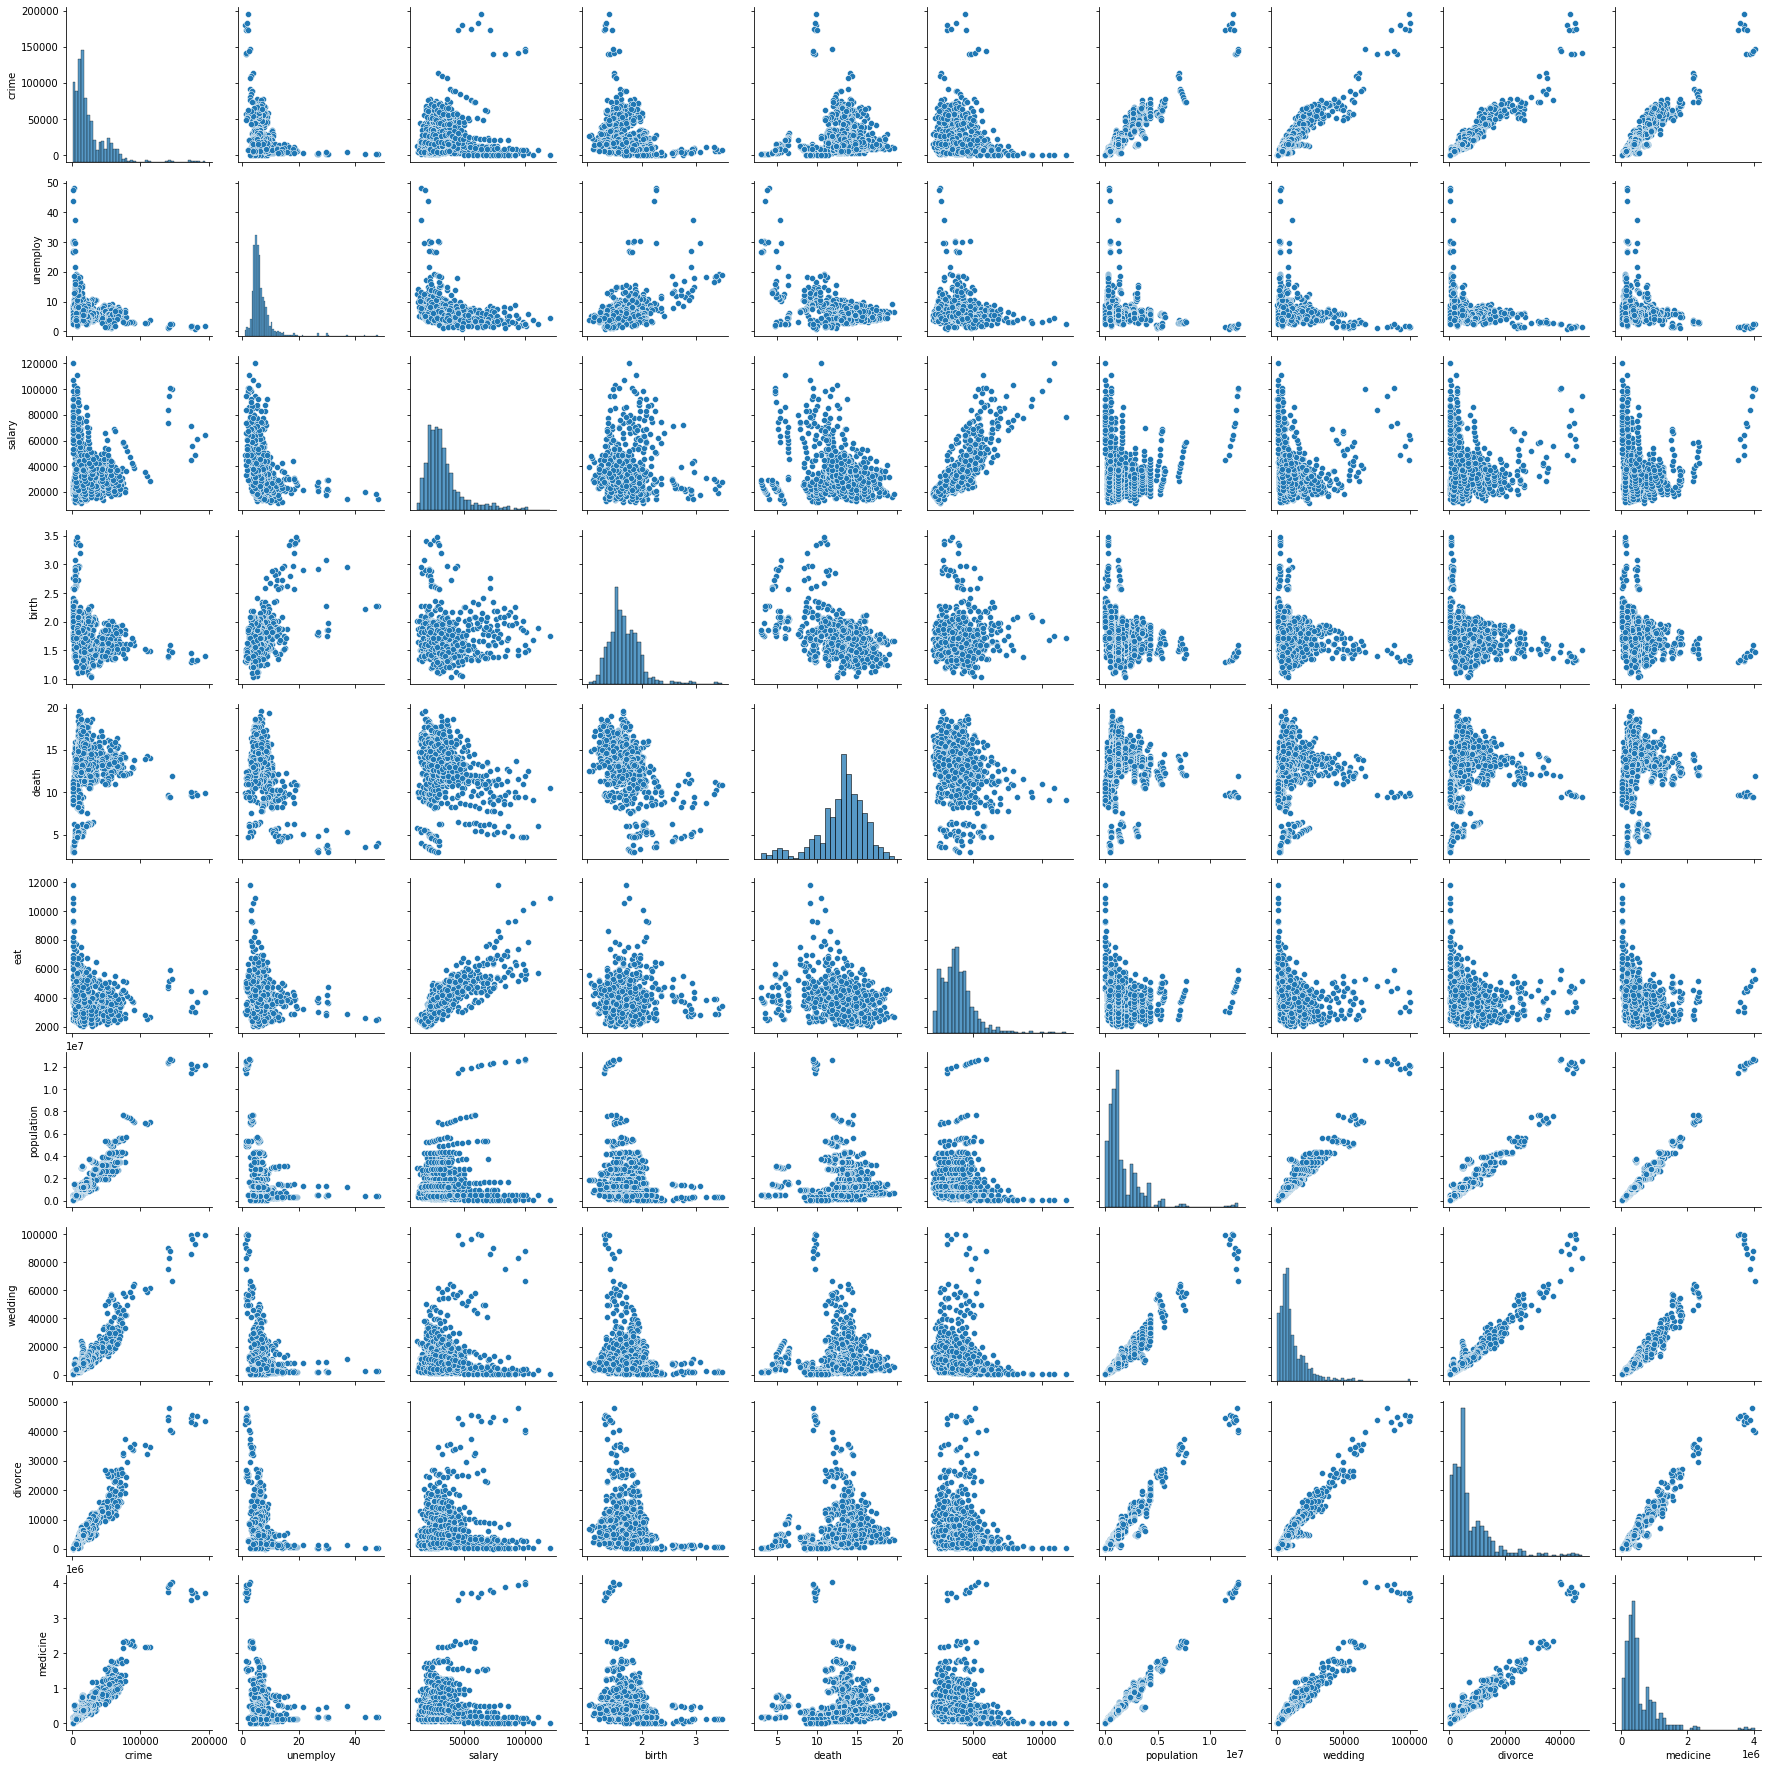

In [73]:
sns.pairplot(all_data)
all_data.corr()

<AxesSubplot:>

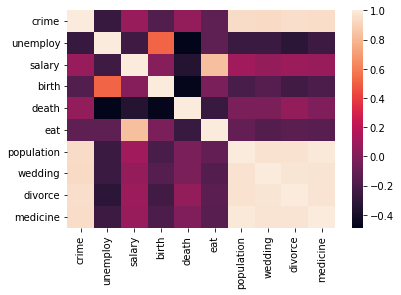

In [74]:
sns.heatmap(all_data.corr())

<AxesSubplot:>

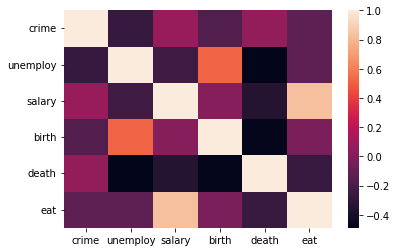

In [75]:
sns.heatmap(all_data.drop(['wedding', 'population', 'divorce', 'medicine'], axis=1).corr())

Да, достаточно сложно визуально что-либо здесь рассмотреть по причине разнообразия данных.  
Посмотрим вначале на таблицу корреляций признаков:  
1. Отчетливо видно, что на целевую переменную абсолютно точно влияют population, wedding, divorce и medicine. Коэффициент корреляции > 0.93, а это означает линейную зависимость. Это же стоит наблюдать на матрице с графиками зависимости (левый столбец).  
2. Касаемо unemploy	и salary: зависимости не видно, либо она не линейна, поэтому сейчас не очевидно, влияет ли безработица и уровень зарплат на уровень преступности (конкретно на наших данных)  
3. Также стоит обратить внимание на сильную корреляцию между population, wedding, divorce и medicine. На матрице графиков это правый нижний угол. Такая линейная зависимость может мешать обучению модели. Вероятно, придется утрать часть этих переменных.  

Если вернуться к выбросам в столбце целевой переменной, то можно предположить, что в силу линейной зависимости между crime и другими переменными, выбросы в этом столбце будут и выбросами в других столбцах. Посмотрим:

In [76]:
all_data[['crime', 'population', 'wedding', 'divorce', 'medicine']].describe()

,crime,population,wedding,divorce,medicine
count,927.000,927.000,927.000,927.000,927.000
mean,"25,014.691","1,750,528.232","12,616.327","7,372.575","559,004.174"
std,"24,541.246","1,761,776.727","13,753.476","7,288.341","542,519.966"
min,511.000,"42,110.000",159.000,136.000,"11,982.000"
25%,"10,307.000","747,767.500","5,032.000","2,942.000","249,960.000"
50%,"16,909.000","1,196,339.000","8,196.000","5,001.000","398,387.000"
75%,"31,058.500","2,397,836.500","15,343.500","9,735.000","753,530.000"
max,"195,239.000","12,666,565.000","100,482.000","47,980.000","4,028,333.000"


In [77]:
all_data[['region&year', 'crime', 'population', 'wedding', 'divorce', 'medicine']][all_data['crime'] > 80000]

,region&year,crime,population,wedding,divorce,medicine
319,Московская область_2011,"113,869.000",7065211,61380,34821,2165209
320,Московская область_2012,"109,349.000",6912801,59093,32437,2189530
321,Московская область_2013,"107,178.000",7001567,61190,35264,2181698
322,Московская область_2014,"91,061.000",7090852,64473,35560,2201209
323,Московская область_2015,"89,183.000",7182344,63451,33718,2243913
324,Московская область_2016,"88,297.000",7274857,55034,33910,2340447
325,Московская область_2017,"84,307.000",7371058,58557,34788,2273198
326,Московская область_2018,"80,299.000",7463427,49339,29415,2305058
902,г. Москва_2011,"173,628.000",11461631,99490,44446,3514721
903,г. Москва_2012,"180,240.000",11816671,92843,42385,3720249


Если сравнивать максимальные значения crime и максимальные значения остальных коррелирующих столбцов, то видно, что все эти значения собраны в одних строчках. Не случайно в вывод добавлен столбец с регионом. Это дает нам понять, почему здесь присутствуют такие значения: в Москве и Московской области действительно проживает большее количество людей, чем в других регионах. Собственно, поэтому и количество посетивших мед учреждения, а также женившихся и развёвшихся не в пример больше.  
Перепроверим себя: выведем боксплот и дистплот по вышеуказанным столбцам и сравним с таблицей максимальных значений crime:

Boxplot population


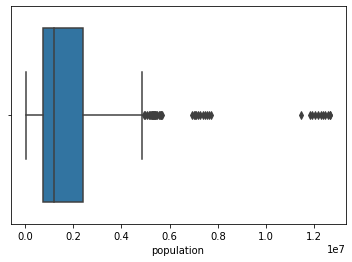

Distplot population


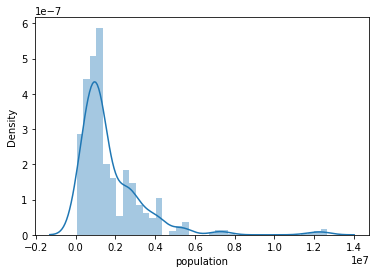

Boxplot wedding


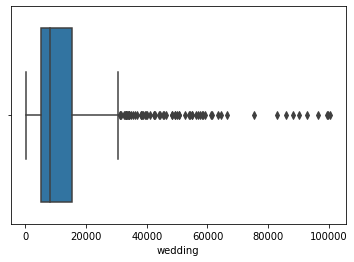

Distplot wedding


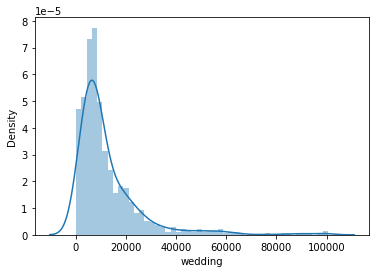

Boxplot divorce


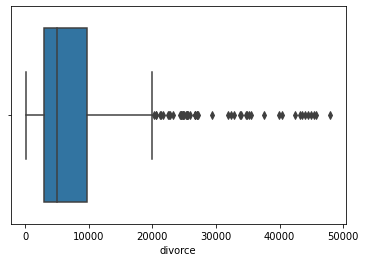

Distplot divorce


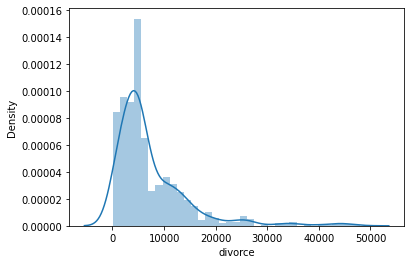

Boxplot medicine


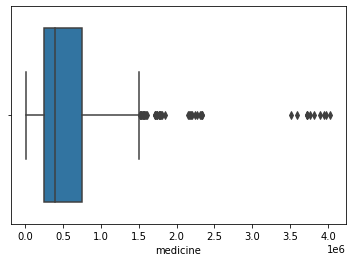

Distplot medicine


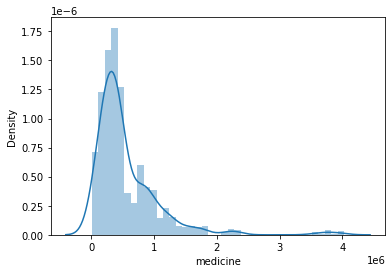

In [78]:
for i in all_data[['population', 'wedding', 'divorce', 'medicine']]:
    plotting(all_data[i])

Да: 
- population: выбросы те же  
- wedding: так же лидирует Москва 
- divorce: та же картина  
- medicine: видно отсутствие значений в интервале от 2,4 до 3,5, а далее снова скопление данных. Это тоже Москва.   

Какой можно сделать вывод: Москва сильно отличается от других регионов - все показатели намного выше среднего. Можно даже сказать, что в этом регионе свои средние значения, поэтому в идеале для Москвы можно было бы обучить свою модель, однако в задаче этого не сказано, поэтому удалять этот регион мы не можем. Оставим всё как есть и перейдём к генерированию фичей:

Поскольку у нас корреляция между доп признаками велика, при этом самая высокая корреляция между population и остальными столбцам, создадим еще 4 столбца:  
1. процент обратившихся в мед учреждения к общему числу постоянно проживающих; 
2. процент женившихся к общему числу проживающих;  
3. процент развёвшихся к популяции;  
4. отношение браков к разводам;

Также стоит обратить внимание, что цель работы - предсказание уровня преступности, а не количества преступлений. Поэтому создадим новый столбец для целевой переменной - процент преступлений на общую численность населения в регионе. Вот такой показатель можно будет считать уровнем:

In [79]:
all_data['med|population'] = (all_data['medicine'] /  all_data['population']) * 100
all_data['wed|population'] = ((all_data['wedding'] * 2) /  all_data['population']) * 100    # числитель умножаем на 2, потому что в регистрации брака обычно участвуют 2 человека
all_data['div|population'] = ((all_data['divorce'] * 2) /  all_data['population']) * 100    # числитель умножаем на 2, потому что в оформлении развода обычно участвуют 2 человека
# all_data['div|wed'] = all_data['divorce'] /  all_data['wedding']
all_data['wed|div'] = (all_data['wedding'] /  all_data['divorce']) * 100
all_data['crime|population'] = (all_data['crime'] /  all_data['population']) * 100
all_data.head()

,region&year,crime,unemploy,salary,birth,death,eat,population,wedding,divorce,medicine,med|population,wed|population,div|population,wed|div,crime|population
0,Алтайский край_2011,"44,940.000",8.500,"13,823.000",1.820,14.600,"2,455.011",2424062,21755,12790,922048,38.037,1.795,1.055,170.094,1.854
1,Алтайский край_2012,"42,102.000",6.200,"16,010.000",1.810,14.600,"2,410.307",2412294,21342,12288,965362,40.018,1.769,1.019,173.682,1.745
2,Алтайский край_2013,"45,024.000",8.300,"18,011.000",1.830,14.200,"2,719.917",2402990,20270,13258,911412,37.928,1.687,1.103,152.889,1.874
3,Алтайский край_2014,"44,096.000",7.200,"19,456.000",1.840,14.200,"2,977.796",2394694,18476,13243,853407,35.637,1.543,1.106,139.515,1.841
4,Алтайский край_2015,"48,582.000",8.000,"20,090.000",1.810,14.100,"3,381.100",2387725,16208,10662,802975,33.629,1.358,0.893,152.017,2.035


In [80]:
data = all_data[['unemploy', 'salary', 'med|population', 'wed|population', 'div|population', 'wed|div', 'crime|population']]
data

,unemploy,salary,med|population,wed|population,div|population,wed|div,crime|population
0,8.500,"13,823.000",38.037,1.795,1.055,170.094,1.854
1,6.200,"16,010.000",40.018,1.769,1.019,173.682,1.745
2,8.300,"18,011.000",37.928,1.687,1.103,152.889,1.874
3,7.200,"19,456.000",35.637,1.543,1.106,139.515,1.841
4,8.000,"20,090.000",33.629,1.358,0.893,152.017,2.035
...,...,...,...,...,...,...,...
930,4.600,"27,687.000",26.723,2.044,0.928,220.143,1.150
931,4.300,"31,814.000",28.302,1.546,0.896,172.601,0.944
932,3.900,"34,621.000",27.549,1.738,0.925,187.912,0.963
933,4.600,"36,300.000",30.175,1.386,0.864,160.457,1.368


Посмтрим на корреляцию:

In [81]:
data.corr()

,unemploy,salary,med|population,wed|population,div|population,wed|div,crime|population
unemploy,1.000,-0.242,0.254,-0.178,-0.531,0.697,-0.117
salary,-0.242,1.000,-0.155,-0.114,0.221,-0.243,0.148
med|population,0.254,-0.155,1.000,0.331,0.237,0.080,0.217
wed|population,-0.178,-0.114,0.331,1.000,0.659,0.033,0.374
div|population,-0.531,0.221,0.237,0.659,1.000,-0.603,0.517
wed|div,0.697,-0.243,0.080,0.033,-0.603,1.000,-0.335
crime|population,-0.117,0.148,0.217,0.374,0.517,-0.335,1.000


<AxesSubplot:>

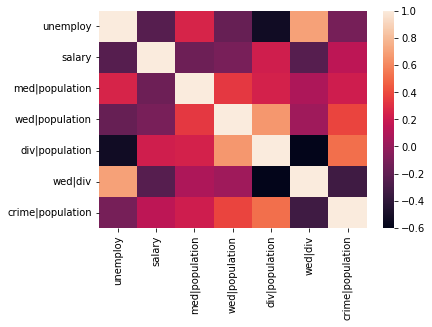

In [82]:
sns.heatmap(data.corr())

Больше такой сильной корреляции нигде нет

Посмотрим также на соотношение безработных к уровню преступности:

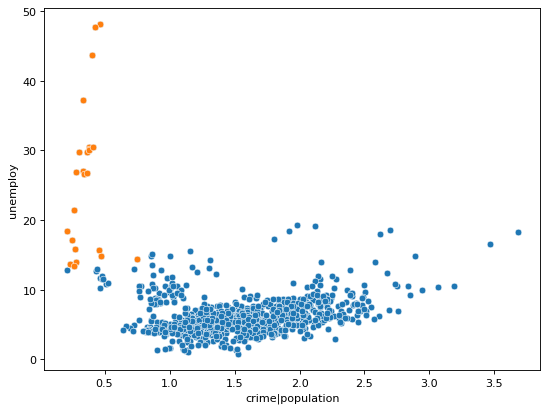

In [83]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot( y="unemploy", x="crime|population",data=data)
sns.scatterplot( y="unemploy", x="crime|population",data=data[(data['crime|population'] < 0.8) & (data['unemploy'] > 13)])
plt.show()

Вот эти самые выбросы:

In [84]:
data[(data['crime|population'] < 0.8) & (data['unemploy'] > 13)].merge(all_data[['region&year']], left_index=True, right_index=True)[['region&year', 'unemploy', 'crime|population']]

,region&year,unemploy,crime|population
203,Карачаево-Черкесская Респ._2016,14.400,0.751
515,Республика Дагестан_2020,15.700,0.456
516,Республика Дагестан_2021,14.900,0.476
517,Республика Ингушетия_2011,48.100,0.468
518,Республика Ингушетия_2012,47.700,0.424
519,Республика Ингушетия_2013,43.700,0.401
520,Республика Ингушетия_2014,29.800,0.363
521,Республика Ингушетия_2015,30.500,0.377
522,Республика Ингушетия_2016,30.200,0.382
523,Республика Ингушетия_2017,27.000,0.337


И соотношение безработицы с заработной платой:

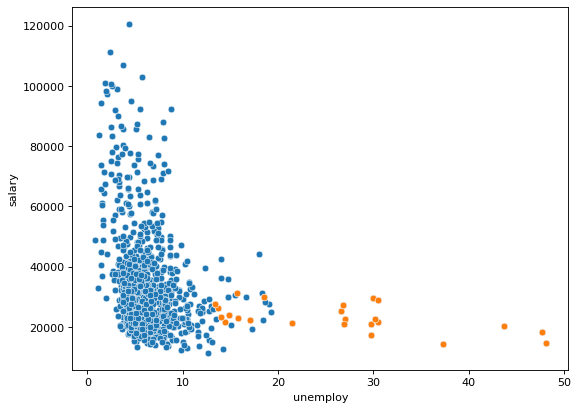

In [85]:
plt.figure(figsize=(8, 6), dpi=80)
sns.scatterplot( y="salary", x="unemploy",data=data)
sns.scatterplot( y="salary", x="unemploy",data=data[(data['unemploy'] > 13) & (data['salary'] < 32000) & (data['crime|population'] < 0.8)])
plt.show()

In [86]:
data[(data['unemploy'] > 13) & (data['salary'] < 32000) & (data['crime|population'] < 0.8)].merge(all_data[['region&year']], left_index=True, right_index=True)[['region&year', 'unemploy', 'salary', 'crime|population']]  # добавим фильтр по преступности (выберем с низкими показателями) 

,region&year,unemploy,salary,crime|population
203,Карачаево-Черкесская Респ._2016,14.400,"21,546.000",0.751
515,Республика Дагестан_2020,15.700,"31,342.000",0.456
516,Республика Дагестан_2021,14.900,"24,070.000",0.476
517,Республика Ингушетия_2011,48.100,"14,513.000",0.468
518,Республика Ингушетия_2012,47.700,"18,302.000",0.424
519,Республика Ингушетия_2013,43.700,"20,151.000",0.401
520,Республика Ингушетия_2014,29.800,"20,993.000",0.363
521,Республика Ингушетия_2015,30.500,"21,481.000",0.377
522,Республика Ингушетия_2016,30.200,"22,488.000",0.382
523,Республика Ингушетия_2017,27.000,"22,750.000",0.337


На графиках разброса и в таблицах, отфильтрованных на основе графиков, мы видим одни и те же регионы. Это Чечня, Ингушетия и Карачаево-Черкессия. При этом Чечня и Ингушетия присутствуют в полном составе - за все годы.  
Эти регионы отличаются низкой заработной платой, высоким уровнем безработности и низким уровнем преступности. Вероятно, дело в строгости местного законодательства. Однако это лишь предположение, вернемся к статистическим данным. Они показывают нехарактерное распределение зависимостей между переменными конкретно в этих регионах.  
Парадокс, который, вероятно, будет влиять на качество предсказания. 

Идем дальше. Теперь посмотрим на разброс значений:

In [87]:
data.describe()

,unemploy,salary,med|population,wed|population,div|population,wed|div,crime|population
count,927.000,927.000,927.000,927.000,927.000,927.000,927.000
mean,6.605,"33,757.932",33.495,1.416,0.858,177.130,1.501
std,4.389,"16,577.434",5.177,0.323,0.210,81.500,0.504
min,0.800,"11,236.000",11.472,0.465,0.110,99.511,0.210
25%,4.400,"23,130.000",30.655,1.176,0.777,144.074,1.163
50%,5.600,"29,441.000",33.073,1.413,0.874,161.150,1.449
75%,7.400,"37,858.000",36.195,1.654,0.971,180.490,1.839
max,48.100,"120,641.000",61.468,2.439,1.448,904.685,3.680


Всё же минимальные показатели кое-где сильно отличаются от максимальных. Поэтому нам необходимо нормализовать данные.  
Для этого вызовем функцию подготовки тренировочного и тестового семпла. Пункт 3:

### Пункт 3. Разбиваем выборку на train и test; обучаем модель регрессии

In [88]:
X_train, X_test, y_train, y_test = prepare_X_and_y(data, 'crime|population')

# X_train, X_test, y_train, y_test = prepare_X_and_y(all_data.drop(['region&year', 'wedding', 'population', 'divorce', 'medicine'], axis=1), 'crime|population')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((621, 6), (306, 6), (621,), (306,))

Теперь переходим к обучению. Обучим пока модель линейной регрессии на двух признаках: зарплата и безработица. Используем коэффициент детерминации как метрику качества работы модели:

0.04306620825785201

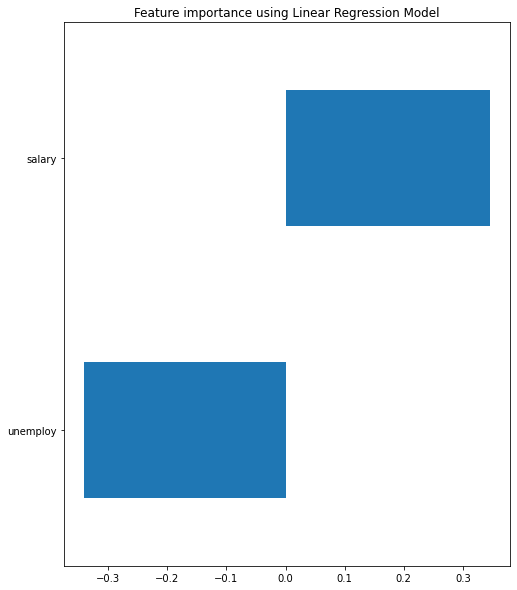

In [89]:
r2 = linear_regression(X_train[['unemploy', 'salary']], y_train, X_test[['unemploy', 'salary']], y_test, X_test[['unemploy', 'salary']].columns)
r2

Судя по полученным данным, эти признаки являются взаимоисключающими, поэтому модель не смогла обучиться как надо. Удалим 2 региона-парадокса из выборки и обучим модель снова:

In [90]:
index_without_outlier = data[(data["unemploy"] > 13) & (data["salary"] < 32000) & (data["crime|population"] < 0.8)].merge(all_data[["region&year"]], left_index=True, right_index=True).index

data_without_outlier = data.query('index not in @index_without_outlier')
data_without_outlier

,unemploy,salary,med|population,wed|population,div|population,wed|div,crime|population
0,8.500,"13,823.000",38.037,1.795,1.055,170.094,1.854
1,6.200,"16,010.000",40.018,1.769,1.019,173.682,1.745
2,8.300,"18,011.000",37.928,1.687,1.103,152.889,1.874
3,7.200,"19,456.000",35.637,1.543,1.106,139.515,1.841
4,8.000,"20,090.000",33.629,1.358,0.893,152.017,2.035
...,...,...,...,...,...,...,...
930,4.600,"27,687.000",26.723,2.044,0.928,220.143,1.150
931,4.300,"31,814.000",28.302,1.546,0.896,172.601,0.944
932,3.900,"34,621.000",27.549,1.738,0.925,187.912,0.963
933,4.600,"36,300.000",30.175,1.386,0.864,160.457,1.368


0.13659063250722958

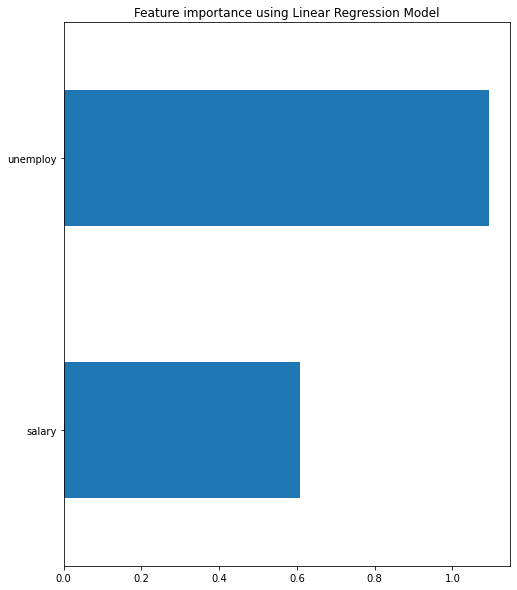

In [91]:
X_train, X_test, y_train, y_test = prepare_X_and_y(data_without_outlier, 'crime|population')

X_train.shape, X_test.shape, y_train.shape, y_test.shape

r2 = linear_regression(X_train[['unemploy', 'salary']], y_train, X_test[['unemploy', 'salary']], y_test, X_test[['unemploy', 'salary']].columns)
r2

Теперь видно, что переменные не противоположны, что хорошо сказалось на обучении модели (R2 вырос).  
Однако нельзя не обратить внимание на то, что теперь в нашей выборке таких регионов больше нет, и, соответственно, в случае, если в новой выборке они появятся, вряд ли модель сможет корректно предсказать уровень преступности для этих регионов.  


 Попробуем снова обучить модель, но уже на всех признаках и выведем признаки по степени значимости:

0.31529429962844135

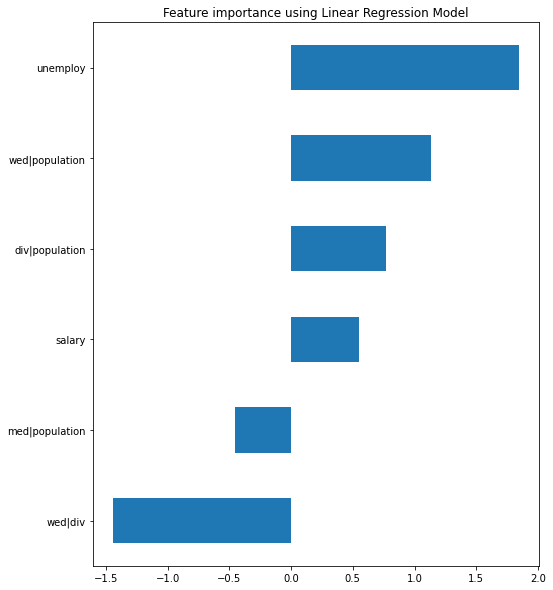

In [92]:
r2_1 = linear_regression(X_train, y_train, X_test, y_test, X_test.columns)
r2_1


Здесь уже интереснее ситуация: наиболее значимыми для модели стали признаки:  
- отношение браков к разводам  
- уровень безработицы  
- отношение количества зарегистрированных в браке людей к общему числу проживающих на территории  

А вот зарплата не оказалась важным признаком.  


Что если вернуться к таблице all_data (где собраны абсолютно все признаки) и попробовать обучить модель на всех признаках сразу, исключая коррелирующие?

In [93]:
X_train_all, X_test_all, y_train, y_test = prepare_X_and_y(all_data.query('index not in @index_without_outlier').drop(['region&year', 'crime', 'wedding', 'divorce', 'medicine'], axis=1), 'crime|population')     # убираем столбец с названиями регионов и столбец отношения преступности и популяции

X_train_all.shape, X_test_all.shape, y_train.shape, y_test.shape

((605, 10), (298, 10), (605,), (298,))

Идём дальше: делим датасет на таргет и фичи, всю выборку на тренировочную и тестовую:

0.44139528055306565

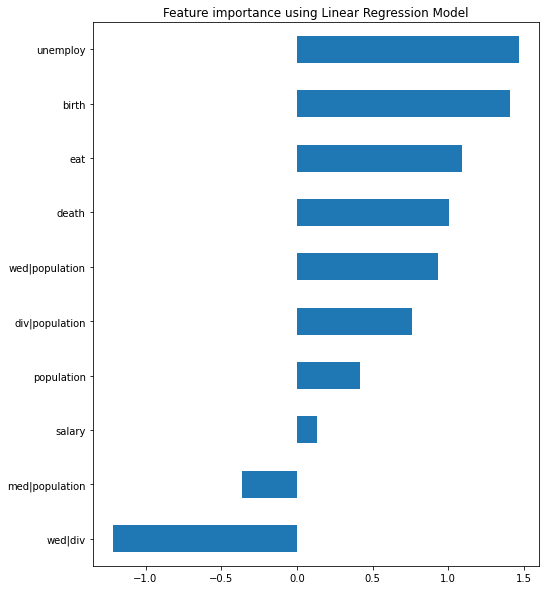

In [94]:
r2_2 = linear_regression(X_train_all, y_train, X_test_all, y_test, X_test_all.columns)
r2_2

А здесь совсем другое дело: и коэффициент детерминации стал выше, и признаков больше. Удивительно, но самыми информативными для модели стали признаки:  
- unemploy  
- birth  
- eat  
- wed|div  
- death
- wed|population  
- div|population  

В таком случае, можно удалить только один неинформативный признак: salary, т.к. он оказался наименее информативным.

In [95]:
X_train_importance, X_test_importance, y_train, y_test = prepare_X_and_y(all_data.query('index not in @index_without_outlier')[['unemploy', 'birth', 'death', 'eat', 'population', 'med|population',
'wed|div', 'wed|population', 'div|population', 'crime|population']], 'crime|population')  # убираем столбец с названиями регионов, столбец c преступностью и коррелирующие

0.4372071709038884

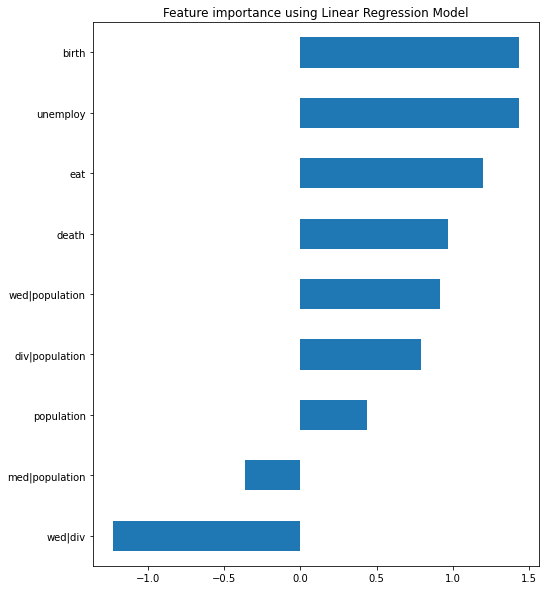

In [96]:
r2_3 = linear_regression(X_train_importance, y_train, X_test_importance, y_test, X_test_importance.columns)
r2_3

Интересно, что исключив зарплату мы получили коэффициент чуть ниже, чем он был до. Значит, для модели уровень заработной платы всё же был важен, но не так сильно, как остальные признаки.

----------------------------
Подытоживая проведённый выше эксперимент, могу сказать, что теория Беккера на этом наборе данных работает только в случае отсутствия двух регионов, которые выбиваются из общей логики.  
Для этого пришлось удалить 24 объекта, что не является критическим решением, однако следует принять во внимание, что, т.к. этих регионов у нас больше нет, в случае возникновения запроса предсказания именно по этим регионам, модель объективно не сможет сделать корректный прогноз.  
С другой стороны, 24 некорректных предсказания на фоне 300+ остальных не будут сильно ухудшать показатель качества.

# Задача 2: User model  

1. Самостоятельно сформулировать критерии, описанные в задаче 1  
2. Построить модель, которая предсказывает уровень преступности по различным переменным (набор переменных определить самостоятельно)

### Пункт 1. Критерии.  
Частично с критериями мы поработали в предыдущей задаче.  
К выбранным критериям относятся:  
- ***unemploy*** - уровень безработицы (он показал хороший результат при обучении модели)
- ***birth***    - суммарный коэффициент рождаемости
- ***death***	 - возрастные коэффициенты смертности
- ***eat***	     - стоимость условного (минимального) набора продуктов питания
- ***population***	- численность постоянного населения в среднем за год
- ***wedding***	   - число зарегистрированных браков
- ***divorce***	   - число разводов за год
- ***medicine***	 - численность лиц, которым оказана помощь амбулаторно и при выездах
- ***med|population***	 - процентное отношение числа пациентов к общей численности постоянного населения, проживающего в регионе
- ***wed|population***	- процентное отношение зарегистрированных браков к общей численности постоянного населения, проживающего в регионе
- ***div|population***	- процентное отношение оформленных разводов к общей численности постоянного населения, проживающего в регионе
- ***wed|div***         - отношение числа зарегистрированных браков к оформленным разводам



Предпочтение отдано именно этим критериям, поскольку каждый из них предположительно может влиять на уровень преступности в регионе.

### Пункт 2. Построение моделей.  

In [97]:
X_train_importance.head()    # еще раз посмотрим на выбранные данные

,unemploy,birth,death,eat,population,med|population,wed|div,wed|population,div|population
0,0.328,0.359,0.595,0.124,0.153,0.454,0.162,0.564,0.554
1,0.164,0.098,0.752,0.235,0.077,0.423,0.080,0.336,0.499
2,0.197,0.147,0.497,0.314,0.076,0.394,0.070,0.518,0.728
3,0.333,0.249,0.634,0.162,0.184,0.451,0.085,0.417,0.575
4,0.333,0.335,0.229,0.487,0.073,0.475,0.170,0.399,0.400


R2 for RandomForestRegressor:  0.7313537193949295


Text(0.5, 1.0, 'Feature importance using RandomForestRegressor Model')

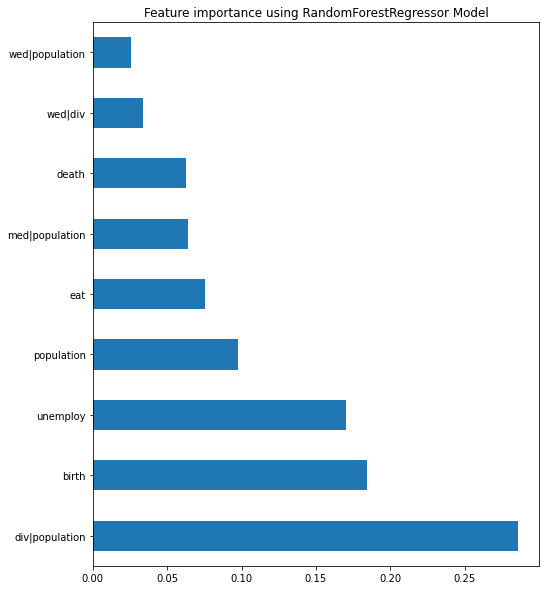

In [98]:
rfr = RandomForestRegressor().fit(X_train_importance, y_train)
rfr_predict = rfr.predict(X_test_importance)
r2_4 = r2_score(y_test, rfr_predict)   
print('R2 for RandomForestRegressor: ', r2_4)

rfr_coef = pd.Series(rfr.feature_importances_, index = X_train_importance.columns)
rfr_imp_coef = rfr_coef.sort_values(ascending=False)
rfr_imp_coef = rfr_imp_coef[:10]

plt.rcParams['figure.figsize'] = (8.0, 10.0)
rfr_imp_coef.plot(kind = "barh")
plt.title("Feature importance using RandomForestRegressor Model")

Переберем параметры:

In [99]:
param_rfr = {'max_depth': np.arange(2, 21, 2), 
             'n_estimators': np.arange(50, 110, 10),
            'min_samples_split': np.arange(2, 21, 2)}

In [100]:
%%time
scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid = GridSearchCV(rfr, param_rfr, scoring=scorer)
# grid = RandomizedSearchCV(rfr, param_distributions= param_rfr, cv = 8, n_jobs=-1, random_state=12345)
grid.fit(X_train_importance, y_train)
print(grid.best_params_)

{'max_depth': 16, 'min_samples_split': 2, 'n_estimators': 100}
CPU times: user 11min 31s, sys: 1.32 s, total: 11min 33s
Wall time: 11min 33s


R2 for RandomForestRegressor:  0.7398349715297713


Text(0.5, 1.0, 'Feature importance using RandomForestRegressor Model')

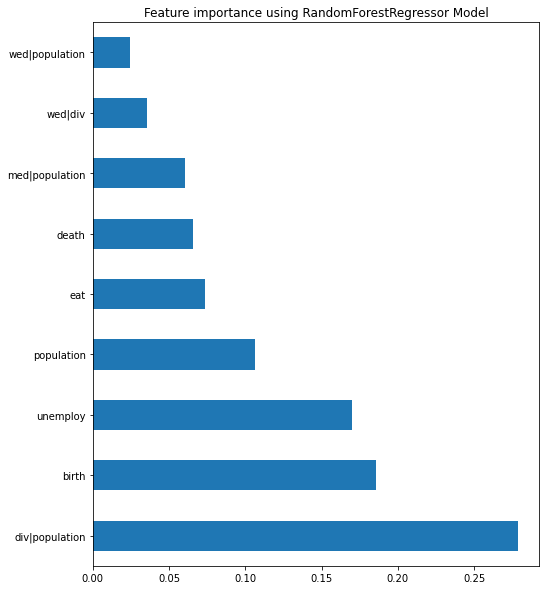

In [101]:
rfr = RandomForestRegressor().set_params(**grid.best_params_).fit(X_train_importance, y_train)
rfr_predict = rfr.predict(X_test_importance)
r2_4 = r2_score(y_test, rfr_predict)   
print('R2 for RandomForestRegressor: ', r2_4)

rfr_coef = pd.Series(rfr.feature_importances_, index = X_train_importance.columns)
rfr_imp_coef = rfr_coef.sort_values(ascending=False)
rfr_imp_coef = rfr_imp_coef[:10]

plt.rcParams['figure.figsize'] = (8.0, 10.0)
rfr_imp_coef.plot(kind = "barh")
plt.title("Feature importance using RandomForestRegressor Model")

R2 здесь еще выше. При этом по значимости признаки поменялись местами: безработица всё также входит в топ-3, а на первом месте отношение разводов к популяции. Рождаемость тоже находится в топ-3 признаков по значимости.  
При этом еще стоит упомянуть о том, что совсем не значимых ля модели признаков здесь нет.

Создадим ансамбль - стекинг из нескольких моделей регрессии:

In [116]:
from sklearn.neighbors import KNeighborsRegressor

regressor = StackingRegressor(   
      [  ('knn', KNeighborsRegressor(n_neighbors=4)),                               # метод ближайших соседей          
         ('rfr', RandomForestRegressor().set_params(**grid.best_params_))], LinearRegression())  # лес (возьмем с уже подобранными параметрами)

Теперь предскажем каждой моделью в отдельности:

In [117]:
regressor.fit(X_train_importance, y_train)
y_pred_knn = regressor.named_estimators_['knn'].predict(X_test_importance)
y_pred_rfr = regressor.named_estimators_['rfr'].predict(X_test_importance)

И стекингом:

In [118]:
y_pred = regressor.predict(X_test_importance)

Сравним показатели:

In [119]:
r2_knn = r2_score(y_test, y_pred_knn)   
print('R2 for KNeighbors: ', r2_knn)

r2_rfr = r2_score(y_test, y_pred_rfr)   
print('R2 for RandomForestRegressor: ', r2_rfr)

r2_regression = r2_score(y_test, y_pred)   
print('R2 for StackingRegressor: ', r2_regression)

result = pd.DataFrame()

result['Model'] = ['KNeighborsRegressor', 'RandomForestRegressor', 'StackingRegressor']
result['R2'] = [r2_knn, r2_rfr, r2_regression]

R2 for KNeighbors:  0.7209743460241291
R2 for RandomForestRegressor:  0.7451525867485398
R2 for StackingRegressor:  0.7735151944697072


Построим гистограмму и посмотрим, показатель какой модели лучше:

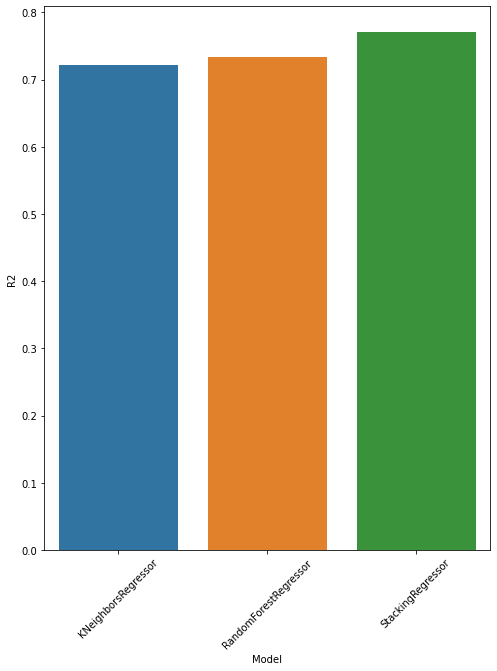

In [106]:
sns.barplot(x='Model', y='R2', data=result)
plt.tick_params(axis='x', rotation=45)

Посмотрим на коэффициенты объединяющей линейной регрессии:

<AxesSubplot:>

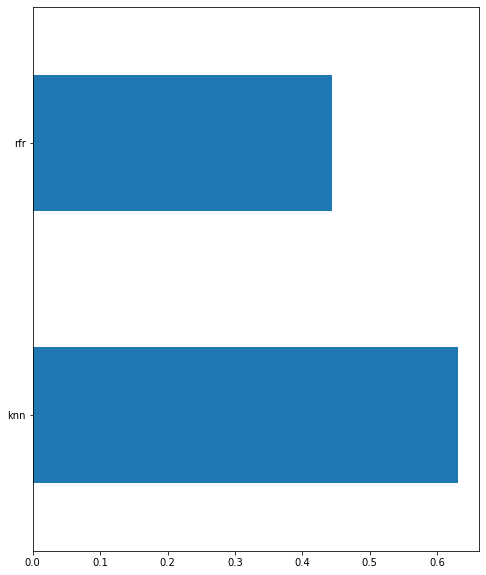

In [107]:
pd.Series(regressor.final_estimator_.coef_.flatten(), index=regressor.named_estimators_.keys()).plot(kind='barh')

Заново выбранные модели для стекинга совместно показали результат лучше, чем ранее. При этом метод ближайших соседей в данном случае стал важнее для линейной регрессии, чем случайный лес. Всё потому, что регионы не перемешаны, каждый регион следует за предыдущим, занимая 11 строчек (содержа информацию по годам), поэтому именно метод ближайших соседей в данном случае будет предпочтительнее.

Переходим к бустинговой модели. LightGBM:

In [108]:
train_data = lgb.Dataset(X_train_importance, label=y_train)
test_data = lgb.Dataset(X_test_importance, label=y_test)

In [109]:
params = {
    'reg_alpha': [0.1, 0.5],
    'max_depth': np.arange(2, 21),
    'n_estimators': np.arange(50, 1101, 50),
    'learning_rate':np.arange(0.1, 0.9, 0.005)
    }

In [110]:
lgb_estimator = lgb.LGBMRegressor(boosting_type='gbdt', metric='R2')

In [112]:
%%time
from sklearn.model_selection import RandomizedSearchCV
grid_search_result = GridSearchCV(lgb_estimator, params, cv = 2, n_jobs=-1)
grid_search_result.fit(X_train_importance, y_train)    

model_lgb = lgb.LGBMRegressor(boosting_type='gbdt', metric='R2').set_params(**grid_search_result.best_params_)
model_lgb.fit(X_train_importance, y_train)
predict_lgb = model_lgb.predict(X_test_importance)

print("LightGBM")
print("R2 for LightGBM:", r2_score(y_test, predict_lgb))


LightGBM
R2 for LightGBM: 0.7010346188617502
CPU times: user 11min, sys: 32.1 s, total: 11min 32s
Wall time: 28min 23s


Результат чуть ниже. Попробуем бустинг добавить в стекинг. Будет ли результат выше?

In [113]:
regressor_1 = StackingRegressor(
          [  ('knn', KNeighborsRegressor(n_neighbors=4)),                  
         ('lgb', lgb.LGBMRegressor(boosting_type='gbdt', metric='R2').set_params(**grid_search_result.best_params_)),      
        ('rfr', RandomForestRegressor().set_params(**grid.best_params_))], LinearRegression())

regressor_1.fit(X_train_importance, y_train)

# Предскажем для каждой модели отдельно:
y_pred_knn_1 = regressor_1.named_estimators_['knn'].predict(X_test_importance)
y_pred_lgb_1 = regressor_1.named_estimators_['lgb'].predict(X_test_importance)
y_pred_rfr_1 = regressor_1.named_estimators_['rfr'].predict(X_test_importance)


# Предскажем для стекинга в целом:
y_pred_1 = regressor_1.predict(X_test_importance)


# Вычислим R2:
r2_knn_1 = r2_score(y_test, y_pred_knn_1)   
print('R2 for KNeighbors: ', r2_knn_1)

r2_lgb_1 = r2_score(y_test, y_pred_lgb_1)   
print('R2 for LinearSVR: ', r2_lgb_1)

r2_rfr_1 = r2_score(y_test, y_pred_rfr_1)   
print('R2 for RandomForestRegressor: ', r2_rfr_1)

r2_regression_1 = r2_score(y_test, y_pred_1)   
print('R2 for StackingRegressor: ', r2_regression_1)


# Запишем результат в датафрейм:
result_1 = pd.DataFrame()

result_1['Model'] = ['KNeighborsRegressor', 'LightGBM', 'RandomForestRegressor', 'StackingRegressor']
result_1['R2'] = [r2_knn_1, r2_lgb_1, r2_rfr_1, r2_regression_1]
result_1

R2 for KNeighbors:  0.7209743460241291
R2 for LinearSVR:  0.7010346188617502
R2 for RandomForestRegressor:  0.7417565868706995
R2 for StackingRegressor:  0.7549880539893422


,Model,R2
0,KNeighborsRegressor,0.721
1,LightGBM,0.701
2,RandomForestRegressor,0.742
3,StackingRegressor,0.755


Результат оказался немного ниже. Это случилось из-за того, что бустинговая модель предсказала результат чуть хуже, поэтому снизила общий показатель работы модели стекинга.

# Вывод

После корректировке данных (мы убрали мешающие обучению признаки) стекинг на основе модели случайного леса и метода ближайших соседей показал самый высокий результат. Бустинговая модель предсказала несколько хуже случайного леса, а для нейросети всё же оказалось слишком мало данных, поэтому она удалена из ноутбука.  

Также заслуживает внимания тот момент, что 2 региона были убраны из выборки полностью, и если бы встала задача предсказания целевой переменной именно для регионов Ингушетии и Чечни, то модель могла бы справиться с задачей хуже, т.к. таких данных в процессе обучения у нее не было. Тем не менее, общая картина от этого только выиграла, т.к выбросы, противоречащие друг другу, были убраны.

И в конце сохраним финальный датасет и самую лучшую модель:

In [123]:
from joblib import dump

dump(regressor, 'stacking_regressor.joblib')

all_data.query('index not in @index_without_outlier').to_excel('Final_data.xlsx', index=False)